
== Basic Statistics ==
count       350.000000
mean      33986.776971
std       92030.261472
min           0.000000
25%         339.260000
50%        2124.345000
75%        9274.560000
max      505845.660000
Name: consumption, dtype: float64

== Missing Values ==
Series([], dtype: int64)

== Yearly Consumption ==
meter_description                                   year
56A TE AWE AWE STREET,HOKOWHITU,PALMERSTON NORTH    2022       4750.81
                                                    2023       3506.71
                                                    2024       3517.71
AQUINAS 74 GLADSTONE ROAD,DUNEDIN                   2022     100175.72
                                                    2023     125758.03
                                                    2024     105619.96
ARANA 110 CLYDE STREET,DUNEDIN                      2022     108068.86
                                                    2023     104070.66
                                                    2024    

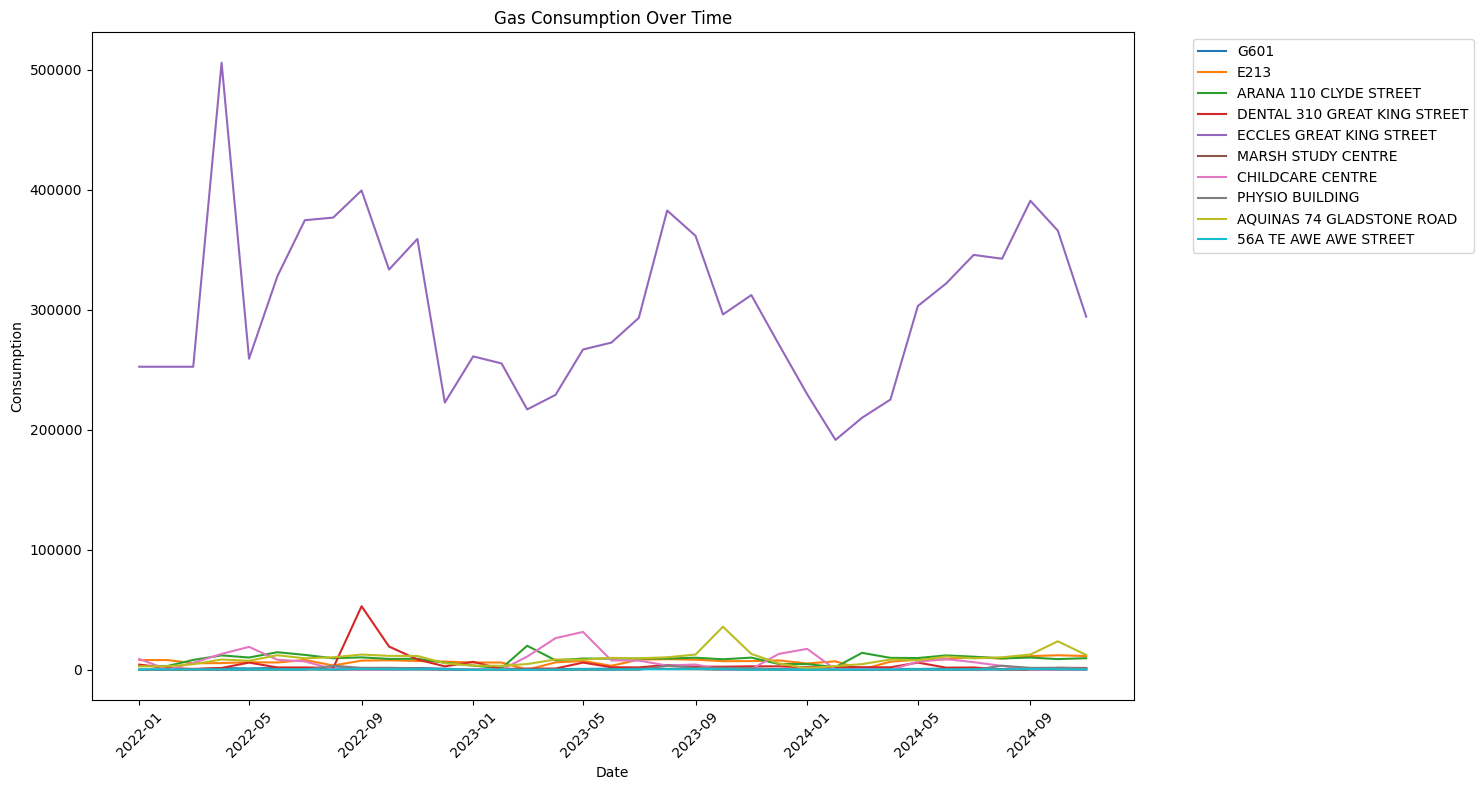

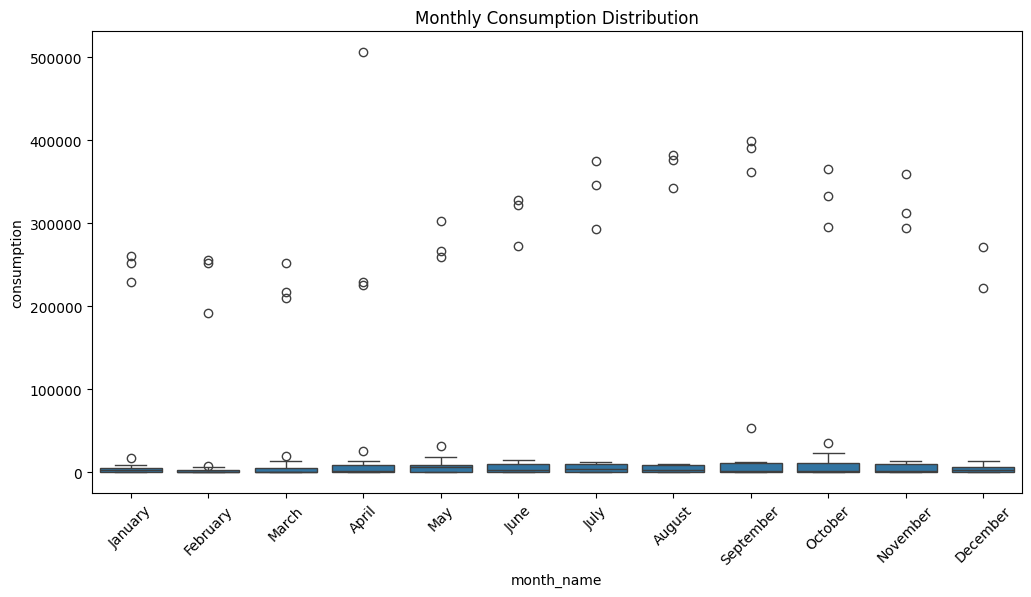

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def load_and_prepare_data(file_path):
    # Read CSV file

    BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
    METER_PATH = BASE_DIR / "backend/data/Cleaned" / file_path
    df = pd.read_csv(METER_PATH)


    # Melt the dataframe to convert months to rows
    df_melted = pd.melt(df, 
                        id_vars=['meter_description'],
                        var_name='month',
                        value_name='consumption')
    
    # Convert month column to datetime
    df_melted['month'] = pd.to_datetime(df_melted['month'], format='%b_%Y')
    
    return df, df_melted

def analyze_data(df, df_melted):
    """Perform comprehensive data analysis"""
    
    # 1. Basic Statistics
    print("\n== Basic Statistics ==")
    print(df_melted['consumption'].describe())
    
    # 2. Check for missing values
    print("\n== Missing Values ==")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 3. Yearly Consumption Analysis
    df_melted['year'] = df_melted['month'].dt.year
    yearly_consumption = df_melted.groupby(['meter_description', 'year'])['consumption'].sum()
    print("\n== Yearly Consumption ==")
    print(yearly_consumption)
    
    return yearly_consumption

def plot_trends(df_melted):
    """Create visualizations"""
    
    # 1. Time Series Plot
    plt.figure(figsize=(15, 8))
    for building in df_melted['meter_description'].unique():
        data = df_melted[df_melted['meter_description'] == building]
        plt.plot(data['month'], data['consumption'], label=building.split(',')[0])
    
    plt.title('Gas Consumption Over Time')
    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 2. Box Plot for Monthly Distribution
    plt.figure(figsize=(12, 6))
    df_melted['month_name'] = df_melted['month'].dt.strftime('%B')
    sns.boxplot(x='month_name', y='consumption', data=df_melted)
    plt.title('Monthly Consumption Distribution')
    plt.xticks(rotation=45)
    plt.show()

# Main execution
try:
    # Load data
    df, df_melted = load_and_prepare_data("gas_automated_meter_cleaned.csv")
    
    # Perform analysis
    yearly_consumption = analyze_data(df, df_melted)
    
    # Create visualizations
    plot_trends(df_melted)
    
except Exception as e:
    print(f"Error in execution: {e}")


In [14]:
df_filtered = df[df['meter_description'] != 'ECCLES GREAT KING STREET,UNIVERSITY OF']

df_eccles = df[df['meter_description'] == 'ECCLES GREAT KING STREET,UNIVERSITY OF']
# Melt the dataframe to convert months to rows
df_melted = pd.melt(df_filtered, 
                    id_vars=['meter_description'],
                    var_name='month',
                    value_name='consumption')

df_melted_eccles = pd.melt(df_eccles, 
                    id_vars=['meter_description'],
                    var_name='month',
                    value_name='consumption')



# Convert month column to datetime
df_melted['month'] = pd.to_datetime(df_melted['month'], format='%b_%Y')
df_melted['year'] = df_melted['month'].dt.year

# Convert month column to datetime
df_melted_eccles['month'] = pd.to_datetime(df_melted_eccles['month'], format='%b_%Y')
df_melted_eccles['year'] = df_melted_eccles['month'].dt.year

In [16]:
def calculate_yearly_differences(df_melted):
    # Calculate yearly consumption for each building
    yearly_consumption = df_melted.groupby(['meter_description', 'year'])['consumption'].sum().reset_index()
    
    # Pivot the data for easier comparison
    yearly_pivot = yearly_consumption.pivot(index='meter_description', 
                                          columns='year', 
                                          values='consumption')
    
    # Calculate differences and percentages
    yearly_pivot['Diff_2022_2023'] = yearly_pivot[2023] - yearly_pivot[2022]
    yearly_pivot['Pct_Change_2022_2023'] = (yearly_pivot['Diff_2022_2023'] / yearly_pivot[2022] * 100).round(2)
    
    yearly_pivot['Diff_2023_2024'] = yearly_pivot[2024] - yearly_pivot[2023]
    yearly_pivot['Pct_Change_2023_2024'] = (yearly_pivot['Diff_2023_2024'] / yearly_pivot[2023] * 100).round(2)
    
    return yearly_pivot

def create_plots(df_melted):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Time Series Plot
    for building in df_melted['meter_description'].unique():
        data = df_melted[df_melted['meter_description'] == building]
        building_name = building.split(',')[0]  # Use first part of building name
        ax1.plot(data['month'], data['consumption'], label=building_name)
    
    ax1.set_title('Gas Consumption Over Time (Excluding ECCLES)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Consumption')
    ax1.legend(bbox_to_anchor=(1.05, 1))
    ax1.tick_params(axis='x', rotation=45)
    
    # Yearly Comparison Bar Plot
    yearly_data = df_melted.groupby(['meter_description', 'year'])['consumption'].sum().reset_index()
    buildings = yearly_data['meter_description'].unique()
    x = np.arange(len(buildings))
    width = 0.25
    
    # Plot bars for each year
    ax2.bar(x - width, yearly_data[yearly_data['year'] == 2022]['consumption'], 
            width, label='2022')
    ax2.bar(x, yearly_data[yearly_data['year'] == 2023]['consumption'], 
            width, label='2023')
    ax2.bar(x + width, yearly_data[yearly_data['year'] == 2024]['consumption'], 
            width, label='2024')
    
    ax2.set_title('Yearly Consumption by Building')
    ax2.set_xlabel('Buildings')
    ax2.set_ylabel('Total Yearly Consumption')
    ax2.set_xticks(x)
    ax2.set_xticklabels([b.split(',')[0] for b in buildings], rotation=45, ha='right')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


Yearly Consumption and Changes:
year                                                     2022       2023  \
meter_description                                                          
56A TE AWE AWE STREET,HOKOWHITU,PALMERSTON NORTH      4750.81    3506.71   
AQUINAS 74 GLADSTONE ROAD,DUNEDIN                   100175.72  125758.03   
ARANA 110 CLYDE STREET,DUNEDIN                      108068.86  104070.66   
CHILDCARE CENTRE,563 CASTLE STREET,DUNEDIN           64385.54  107013.02   
DENTAL 310 GREAT KING STREET,DUNEDIN NORTH,DUNEDIN  103409.88   34616.10   
E213,PARKER BUILDING,344 GREAT KING                  81321.25   77093.82   
G601,UNIVERSITY COLLEGE (KITCHEN),315 LEITH          12334.47    7814.27   
MARSH STUDY CENTRE,CASTLE STREET,DUNEDIN              1659.72    2976.87   
PHYSIO BUILDING, 325 GREAT KING ST                    7948.00    7948.00   

year                                                     2024  Diff_2022_2023  \
meter_description                                

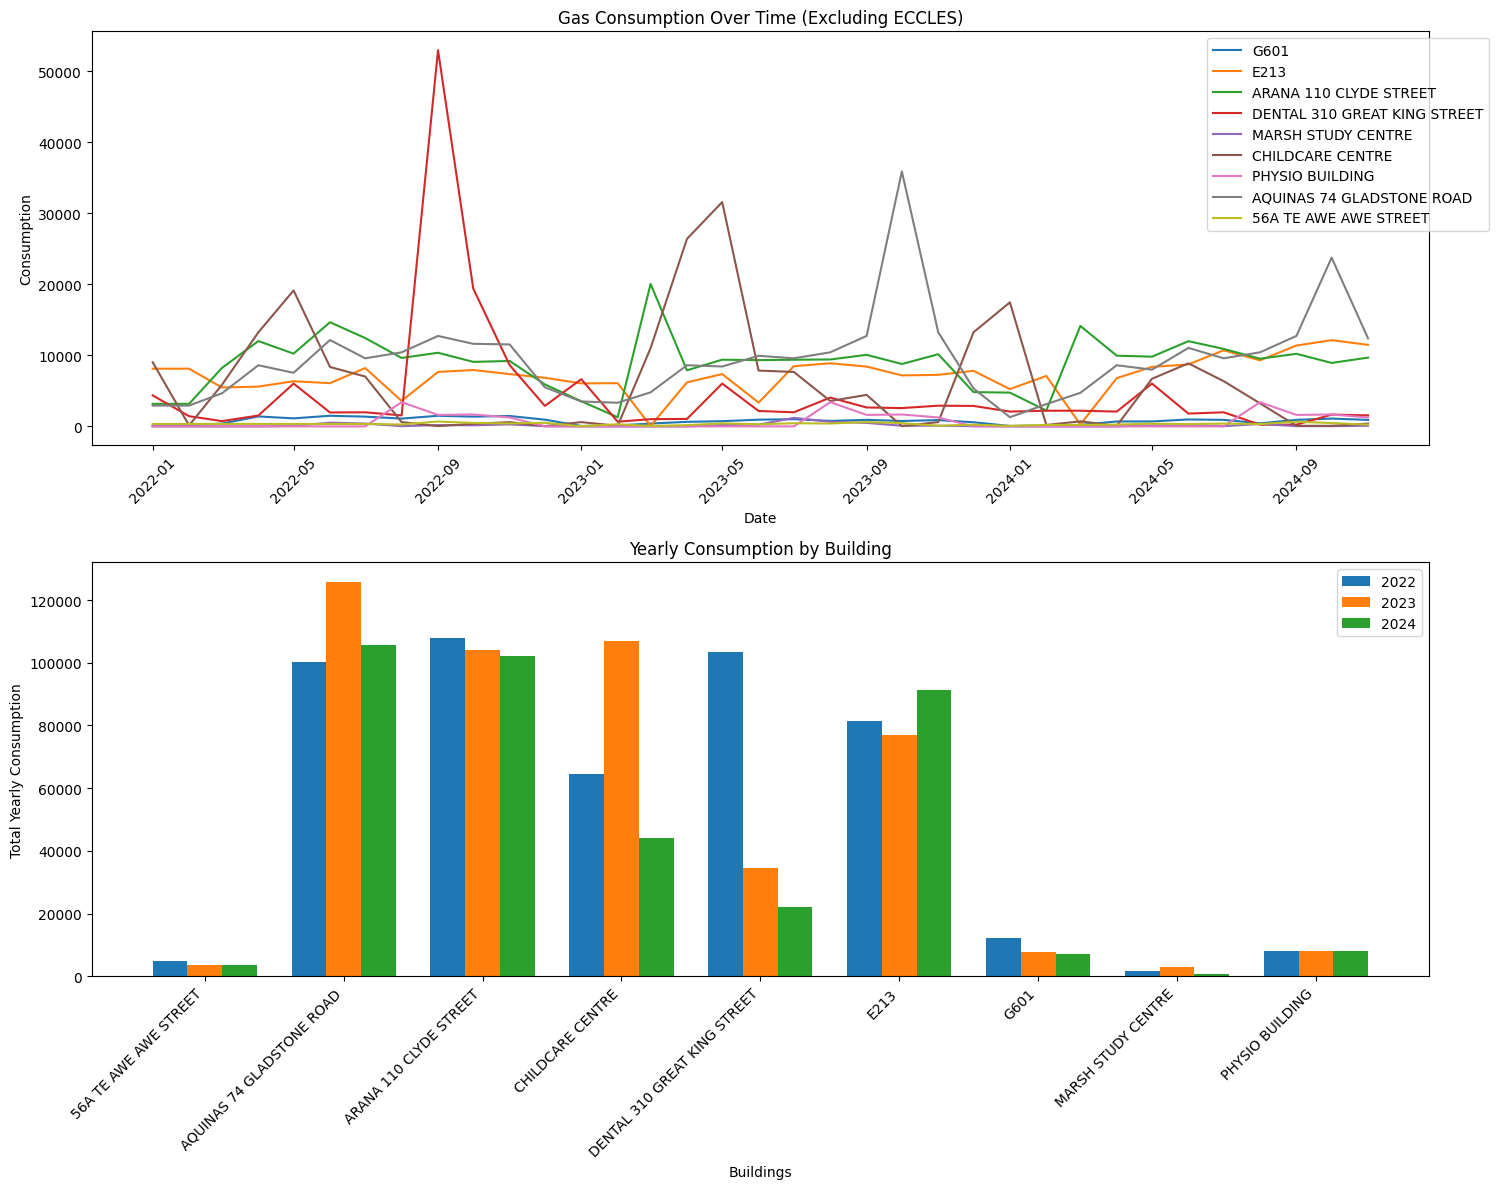

In [17]:
yearly_comparison = calculate_yearly_differences(df_melted)
print("\nYearly Consumption and Changes:")
print(yearly_comparison)

# Create visualizations
create_plots(df_melted)


Yearly Consumption and Changes:
year                                          2022        2023       2024  \
meter_description                                                           
ECCLES GREAT KING STREET,UNIVERSITY OF  3916415.42  3418906.72  3220419.0   

year                                    Diff_2022_2023  Pct_Change_2022_2023  \
meter_description                                                              
ECCLES GREAT KING STREET,UNIVERSITY OF       -497508.7                 -12.7   

year                                    Diff_2023_2024  Pct_Change_2023_2024  
meter_description                                                             
ECCLES GREAT KING STREET,UNIVERSITY OF      -198487.72                 -5.81  


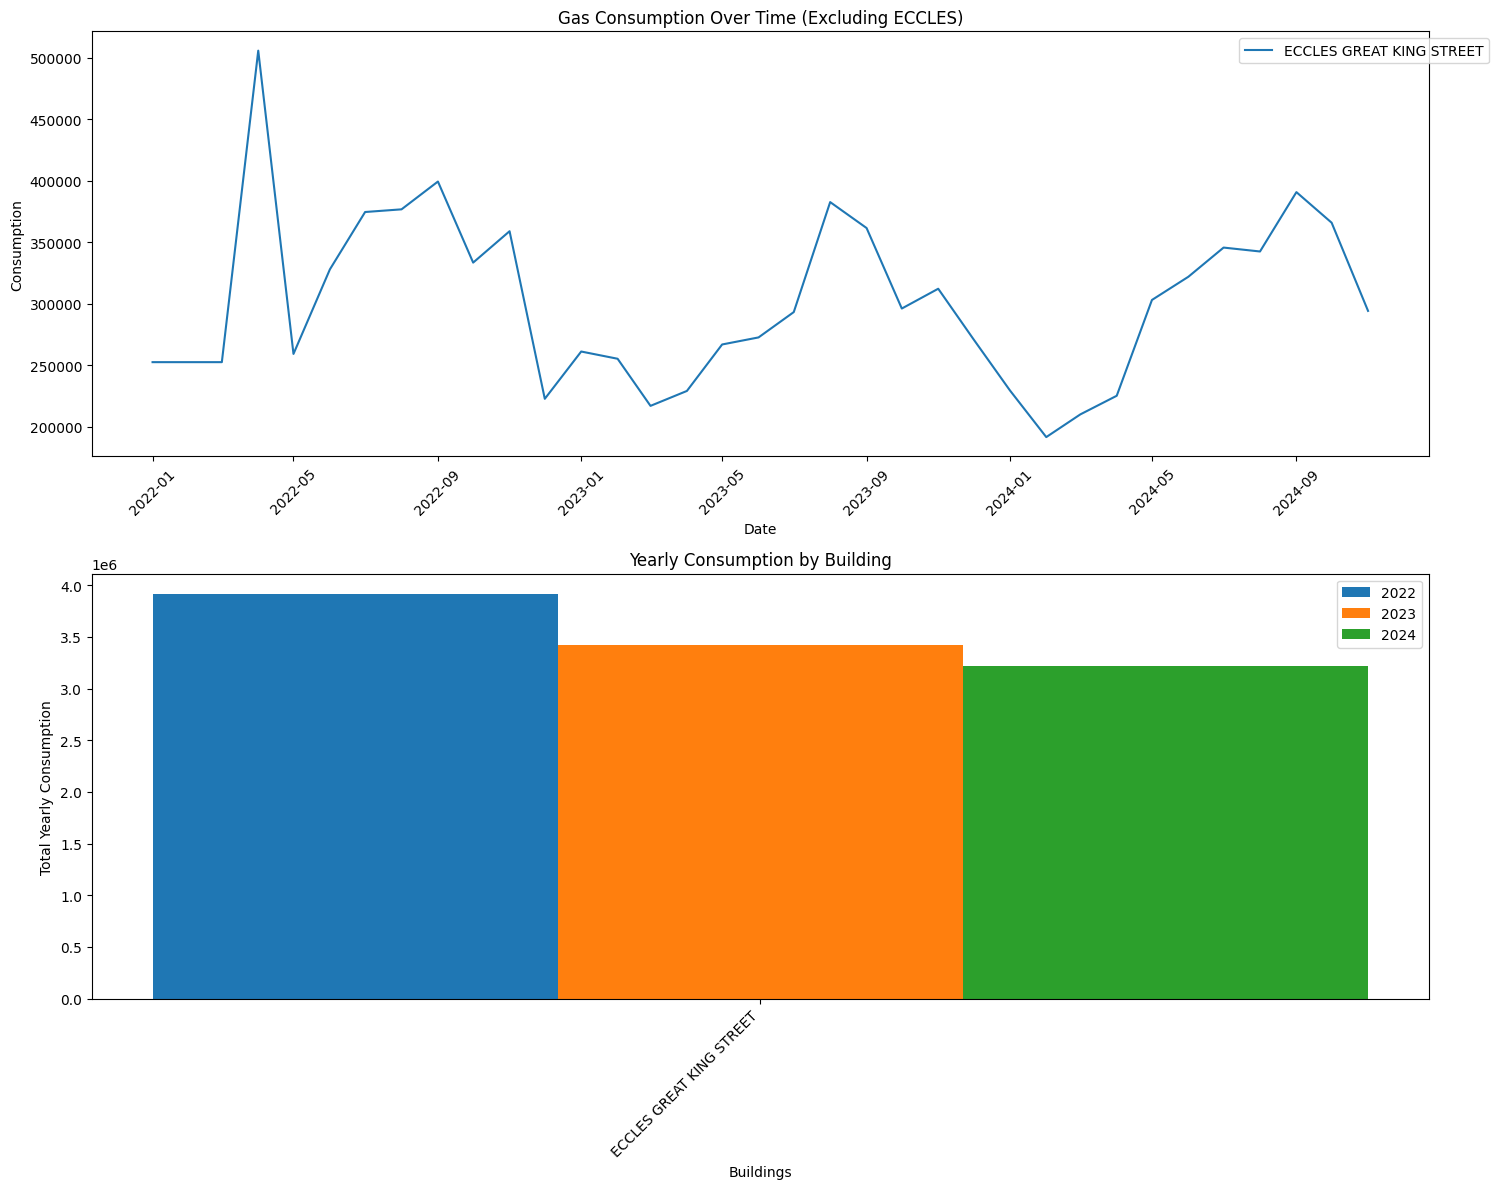

In [18]:
yearly_comparison = calculate_yearly_differences(df_melted_eccles)
print("\nYearly Consumption and Changes:")
print(yearly_comparison)

# Create visualizations
create_plots(df_melted_eccles)

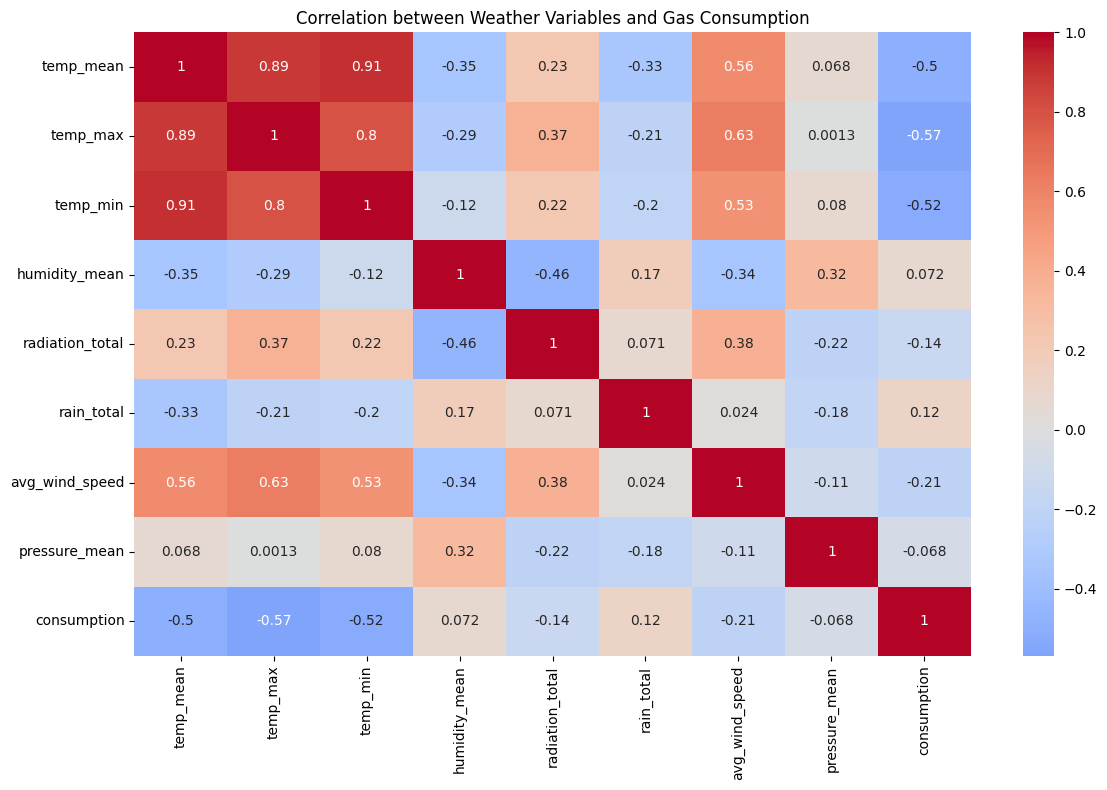


Statistical Summary:

Weather Data Statistics:
       temp_mean   temp_max   temp_min  humidity_mean  radiation_total  \
count  35.000000  35.000000  35.000000      35.000000     3.500000e+01   
mean   13.544382  23.422000   5.062343      64.320709     3.061542e+06   
std     3.010834   4.124962   3.703987       4.248893     2.652652e+06   
min     8.767209  16.590000  -1.100000      55.371280     3.988578e+05   
25%    10.759897  20.225000   1.671000      61.251928     1.007929e+06   
50%    13.596058  23.100000   5.352000      64.395338     1.822046e+06   
75%    16.153294  26.100000   8.790000      67.307034     5.058180e+06   
max    19.141647  31.100000  12.500000      71.850689     8.258166e+06   

       rain_total  avg_wind_speed  pressure_mean  
count   35.000000       35.000000      35.000000  
mean    25.314286        3.359062    1008.573380  
std     23.224494        0.499098       3.468777  
min      3.800000        1.847772    1000.981267  
25%     14.100000        3.067

In [23]:
BASE_DIR = Path(os.getcwd()).parents[2] 
WEATHER_PATH = BASE_DIR / "backend/data/Weather/Load_weather_monthly.csv"

# Read the CSV files
weather_df = pd.read_csv(WEATHER_PATH)
gas_df = df_filtered

weather_df['Month'] = weather_df['Month'].astype(str).str.zfill(2)
    
# Create date column for proper merging
weather_df['date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + weather_df['Month'].astype(str) + '-01')

# Melt gas data
gas_melted = pd.melt(gas_df, 
                    id_vars=['meter_description'],
                    var_name='date',
                    value_name='consumption')

# Convert gas data date format
gas_melted['date'] = pd.to_datetime(gas_melted['date'], format='%b_%Y')

# Group gas data by date
gas_grouped = gas_melted.groupby('date')['consumption'].sum().reset_index()

# Merge weather and gas data
merged_data = pd.merge(weather_df, gas_grouped, on='date')

# Select relevant weather variables for correlation
weather_vars = ['temp_mean', 'temp_max', 'temp_min', 'humidity_mean', 
                'radiation_total', 'rain_total', 'avg_wind_speed', 'pressure_mean']

# Calculate correlation matrix
correlation_matrix = merged_data[weather_vars + ['consumption']].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Gas Consumption')
plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
print("\nWeather Data Statistics:")
print(merged_data[weather_vars].describe())

print("\nGas Consumption Statistics:")
print(merged_data['consumption'].describe())

# Calculate specific correlations with consumption
correlations = correlation_matrix['consumption'].sort_values(ascending=False)
print("\nCorrelations with Gas Consumption:")
print(correlations)


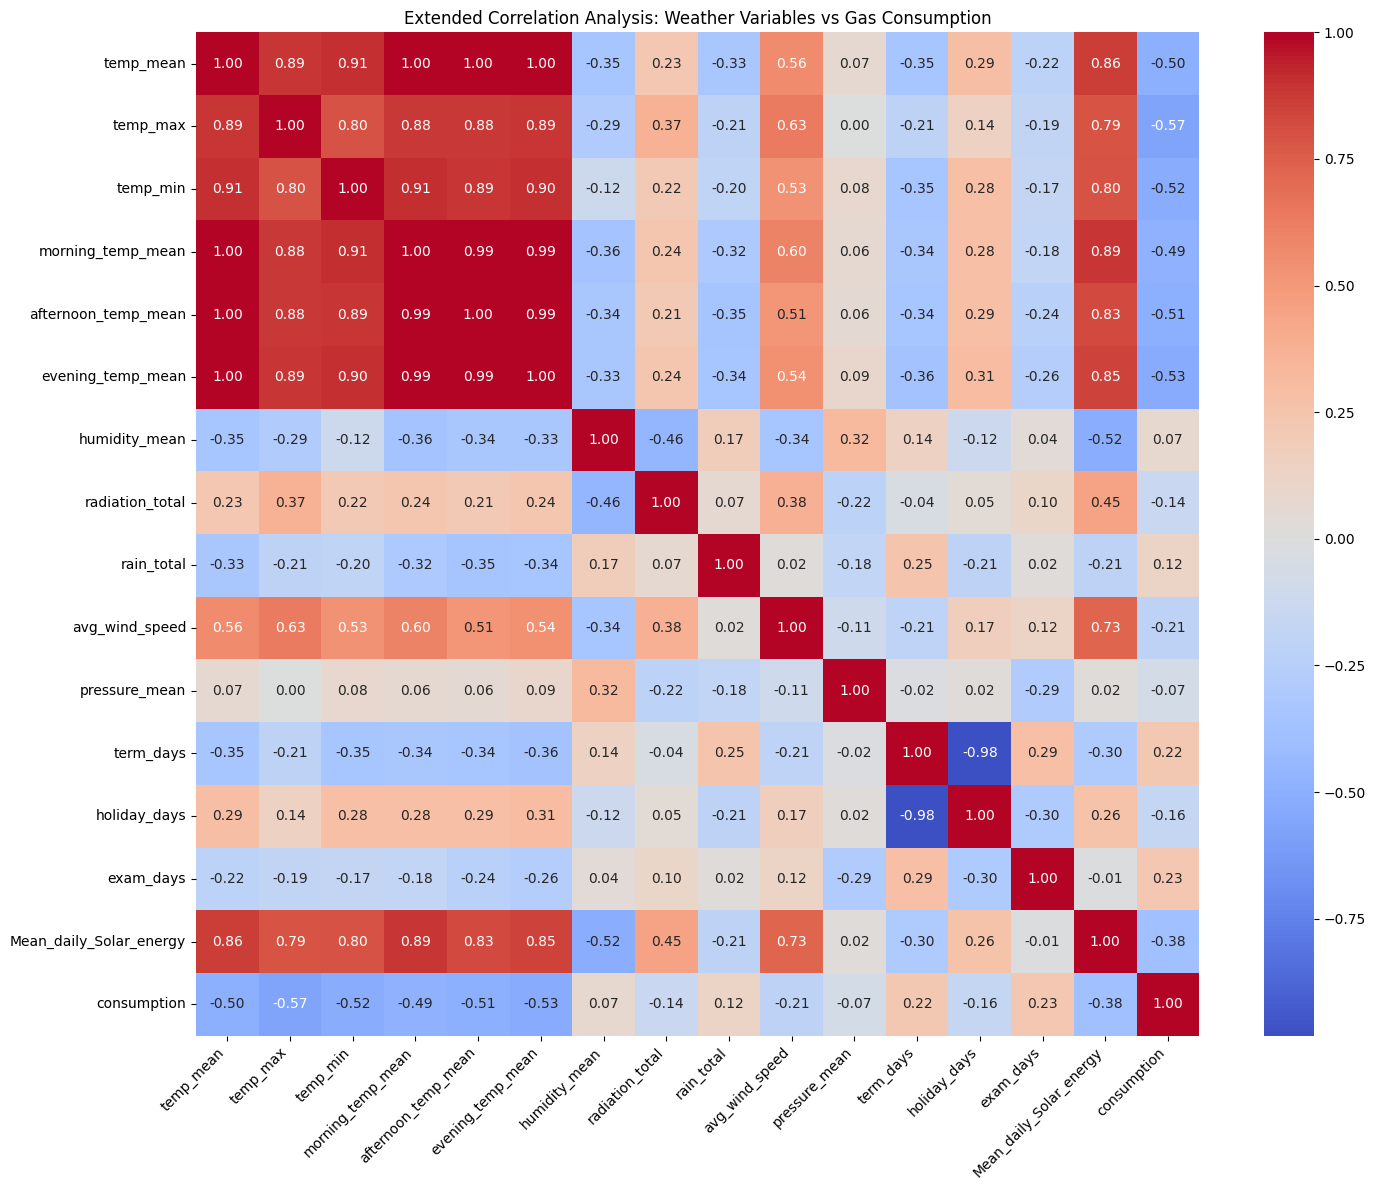

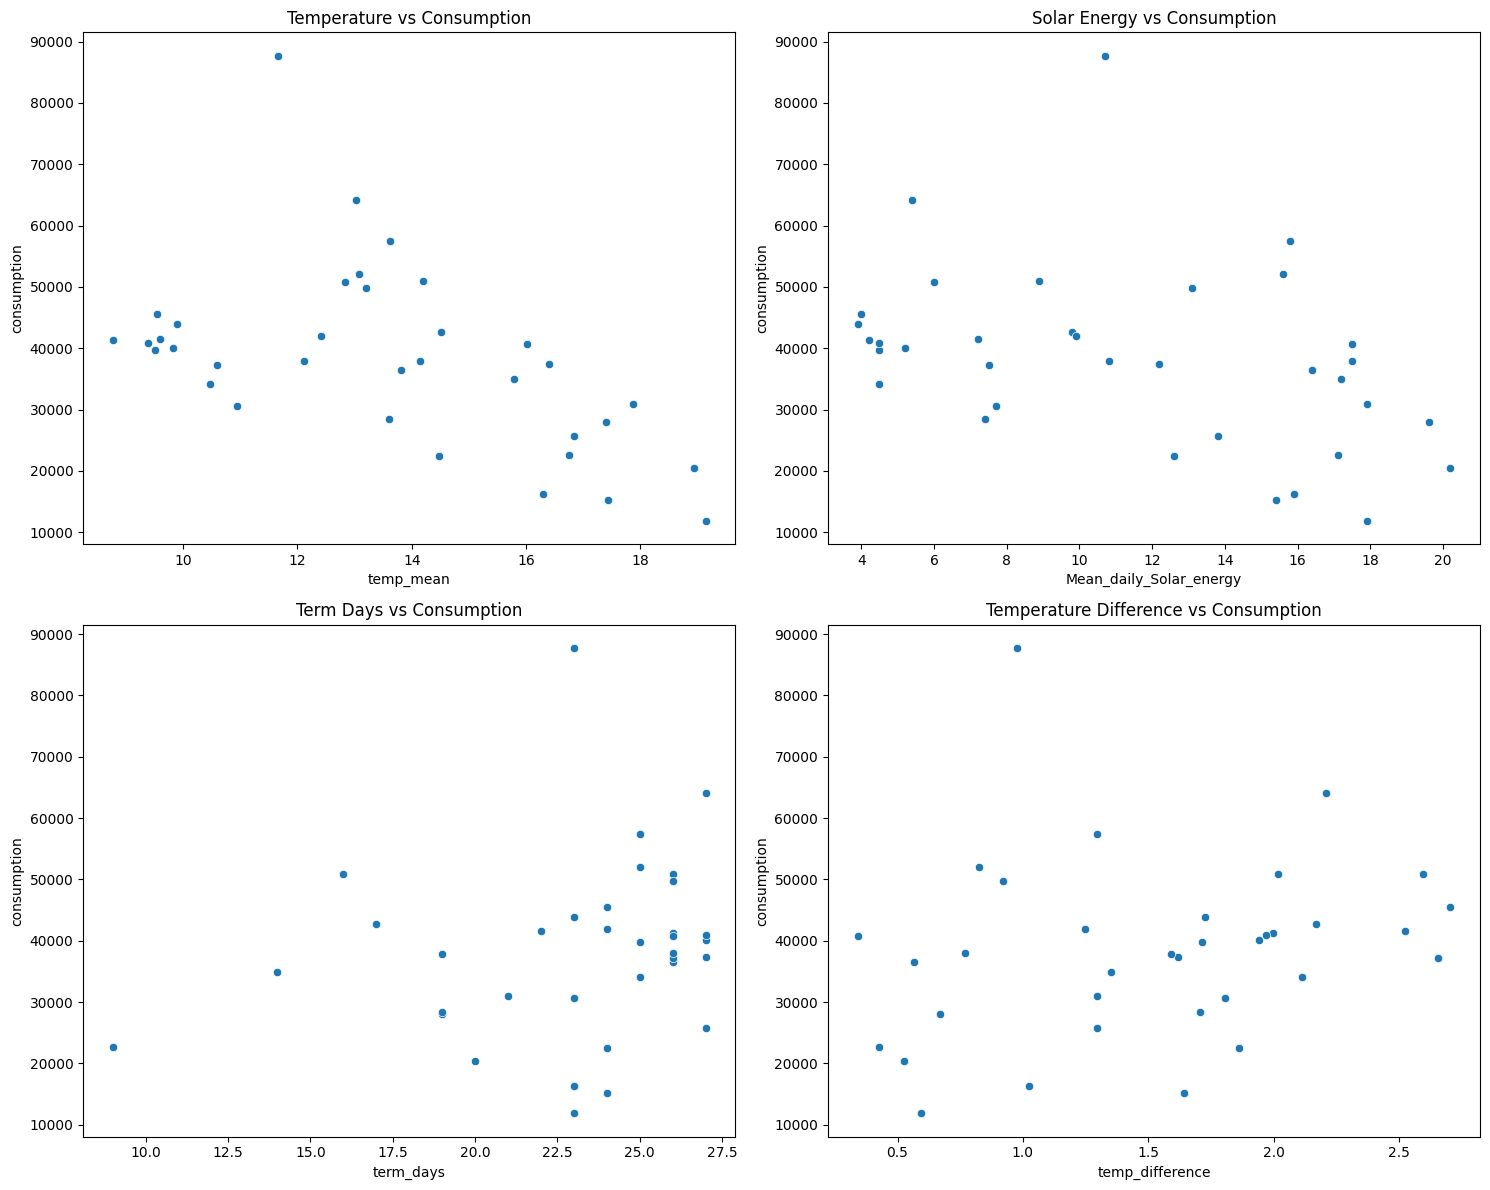

In [26]:
def analyze_extended_correlations(data):
    # Select extended set of variables including derived features
    variables = [
        'temp_mean', 'temp_max', 'temp_min',
        'morning_temp_mean', 'afternoon_temp_mean', 'evening_temp_mean',
        'humidity_mean', 'radiation_total', 'rain_total',
        'avg_wind_speed', 'pressure_mean',
        'term_days', 'holiday_days', 'exam_days',
        'Mean_daily_Solar_energy',
        'consumption'
    ]
    
    # Calculate correlations
    correlation_matrix = data[variables].corr()
    
    # Create heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Extended Correlation Analysis: Weather Variables vs Gas Consumption')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Create scatter plots for key relationships
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Temperature vs Consumption
    sns.scatterplot(data=data, 
                   x='temp_mean', 
                   y='consumption',
                   ax=axes[0,0])
    axes[0,0].set_title('Temperature vs Consumption')
    
    # Plot 2: Solar Energy vs Consumption
    sns.scatterplot(data=data,
                   x='Mean_daily_Solar_energy',
                   y='consumption',
                   ax=axes[0,1])
    axes[0,1].set_title('Solar Energy vs Consumption')
    
    # Plot 3: Term Days vs Consumption
    sns.scatterplot(data=data,
                   x='term_days',
                   y='consumption',
                   ax=axes[1,0])
    axes[1,0].set_title('Term Days vs Consumption')
    
    # Plot 4: Morning vs Evening Temperature Difference
    data['temp_difference'] = data['afternoon_temp_mean'] - data['morning_temp_mean']
    sns.scatterplot(data=data,
                   x='temp_difference',
                   y='consumption',
                   ax=axes[1,1])
    axes[1,1].set_title('Temperature Difference vs Consumption')
    
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Create some derived features
def add_derived_features(data):
    data['temp_range'] = data['temp_max'] - data['temp_min']
    data['is_academic_period'] = (data['term_days'] + data['exam_days']) > 0
    data['temp_morning_evening_diff'] = data['evening_temp_mean'] - data['morning_temp_mean']
    return data

# Run correlation analysis
correlation_matrix = analyze_extended_correlations(merged_data)

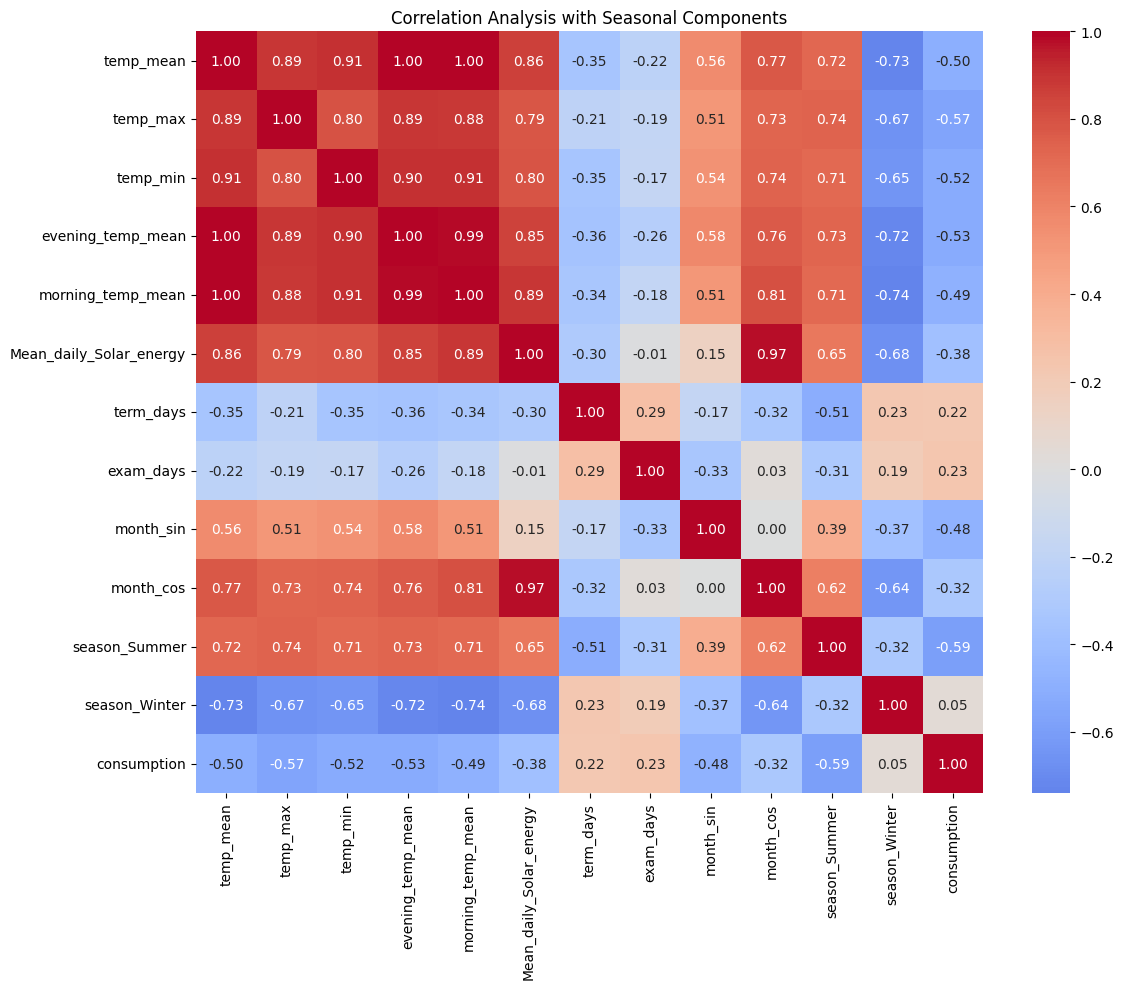

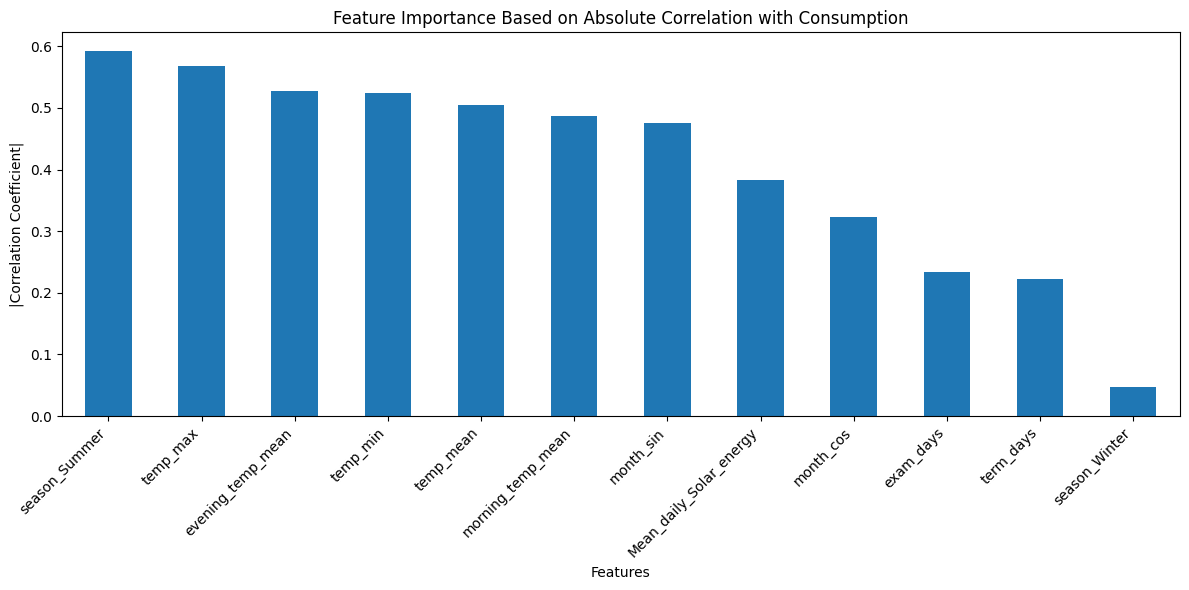


Feature Importance Ranking:
season_Summer              0.592976
temp_max                   0.568355
evening_temp_mean          0.526902
temp_min                   0.524142
temp_mean                  0.504889
morning_temp_mean          0.486956
month_sin                  0.476308
Mean_daily_Solar_energy    0.383240
month_cos                  0.322257
exam_days                  0.233892
term_days                  0.221652
season_Winter              0.047019
Name: consumption, dtype: float64


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def add_seasonal_features(df):
    """Add seasonal and cyclical features to the dataframe"""
    # Add month-based cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    
    # Add seasons (Southern Hemisphere)
    conditions = [
        (df['Month'].isin([12, 1, 2])),
        (df['Month'].isin([3, 4, 5])),
        (df['Month'].isin([6, 7, 8])),
        (df['Month'].isin([9, 10, 11]))
    ]
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    df['season'] = np.select(conditions, seasons, default='Unknown')
    
    # Create dummy variables for seasons
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season_dummies], axis=1)
    
    return df

def analyze_correlations(merged_data):
    """Analyze and visualize correlations with seasonal components"""
    # Select relevant features
    features = [
        'temp_mean', 'temp_max', 'temp_min',
        'evening_temp_mean', 'morning_temp_mean',
        'Mean_daily_Solar_energy',
        'term_days', 'exam_days',
        'month_sin', 'month_cos',
        'season_Summer', 'season_Winter',
        'consumption'
    ]
    
    # Calculate correlation matrix
    correlation_matrix = merged_data[features].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f')
    plt.title('Correlation Analysis with Seasonal Components')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix


def analyze_feature_importance(merged_data):
    """Analyze feature importance based on correlation with consumption"""
    
    # Select features that exist in the dataset before seasonal transformations
    basic_features = [
        'temp_max',           
        'evening_temp_mean',  
        'temp_min',          
        'temp_mean',         
        'morning_temp_mean', 
        'Mean_daily_Solar_energy',
        'term_days',         
        'exam_days'          
    ]
    
    # Add seasonal features if they exist
    all_features = basic_features.copy()
    seasonal_features = ['month_sin', 'month_cos', 'season_Summer', 'season_Winter']
    
    for feature in seasonal_features:
        if feature in merged_data.columns:
            all_features.append(feature)
    
    # Calculate absolute correlations with consumption
    correlations = merged_data[all_features + ['consumption']].corr()['consumption'].abs()
    
    # Sort features by absolute correlation value
    feature_importance = correlations[:-1].sort_values(ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance Based on Absolute Correlation with Consumption')
    plt.xlabel('Features')
    plt.ylabel('|Correlation Coefficient|')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def main():
    # Load and prepare data
    BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
    WEATHER_PATH = BASE_DIR / "backend/data/Weather/Load_weather_monthly.csv"
    METER_PATH = BASE_DIR / "backend/data/Cleaned/gas_automated_meter_cleaned.csv"

    weather_df = pd.read_csv(WEATHER_PATH)
    gas_df = pd.read_csv(METER_PATH)
    
    # Remove ECCLES building
    gas_df = gas_df[gas_df['meter_description'] != 'ECCLES GREAT KING STREET,UNIVERSITY OF']
    
    # Prepare gas consumption data
    gas_melted = pd.melt(gas_df, 
                        id_vars=['meter_description'],
                        var_name='date',
                        value_name='consumption')
    gas_melted['date'] = pd.to_datetime(gas_melted['date'], format='%b_%Y')
    gas_melted['Year'] = gas_melted['date'].dt.year
    gas_melted['Month'] = gas_melted['date'].dt.month
    
    # Convert month names to numbers in weather_df if needed
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    
    # Check if Month is string and needs conversion
    if weather_df['Month'].dtype == 'object':
        weather_df['Month'] = weather_df['Month'].map(month_map)
    
    weather_df['Year'] = weather_df['Year'].astype(int)
    gas_melted['Month'] = gas_melted['Month'].astype(int)
    gas_melted['Year'] = gas_melted['Year'].astype(int)
    
    # Group gas data
    gas_grouped = gas_melted.groupby(['Year', 'Month'])['consumption'].sum().reset_index()
    
    # Merge weather and gas data
    merged_data = pd.merge(weather_df, gas_grouped, on=['Year', 'Month'])
    
    # Add seasonal features
    merged_data = add_seasonal_features(merged_data)
    
    # Analyze correlations
    correlation_matrix = analyze_correlations(merged_data)
    
    # Then analyze feature importance
    feature_importance = analyze_feature_importance(merged_data)
    
    print("\nFeature Importance Ranking:")
    print(feature_importance)
    
    return correlation_matrix, feature_importance

if __name__ == "__main__":
    correlation_matrix, feature_importance = main()


Training Linear Models...

Multiple Linear Regression Performance Metrics:
RMSE: 10351.40
MAE: 9818.59
R2 Score: 0.5194

Ridge Regression Performance Metrics:
RMSE: 10221.23
MAE: 9723.42
R2 Score: 0.5314

Lasso Regression Performance Metrics:
RMSE: 10346.28
MAE: 9816.38
R2 Score: 0.5198

Training Non-linear Models...

Polynomial Regression Performance Metrics:
RMSE: 30116.45
MAE: 22978.88
R2 Score: -3.0684

Random Forest Performance Metrics:
RMSE: 9018.92
MAE: 8299.29
R2 Score: 0.6351

Cross-Validation Results (R² scores):
Linear Regression: Mean R² = -2.4914 (+/- 6.2110)
Ridge: Mean R² = -1.8233 (+/- 5.1535)
Lasso: Mean R² = -2.4807 (+/- 6.1906)
Random Forest: Mean R² = -1.4894 (+/- 4.6794)


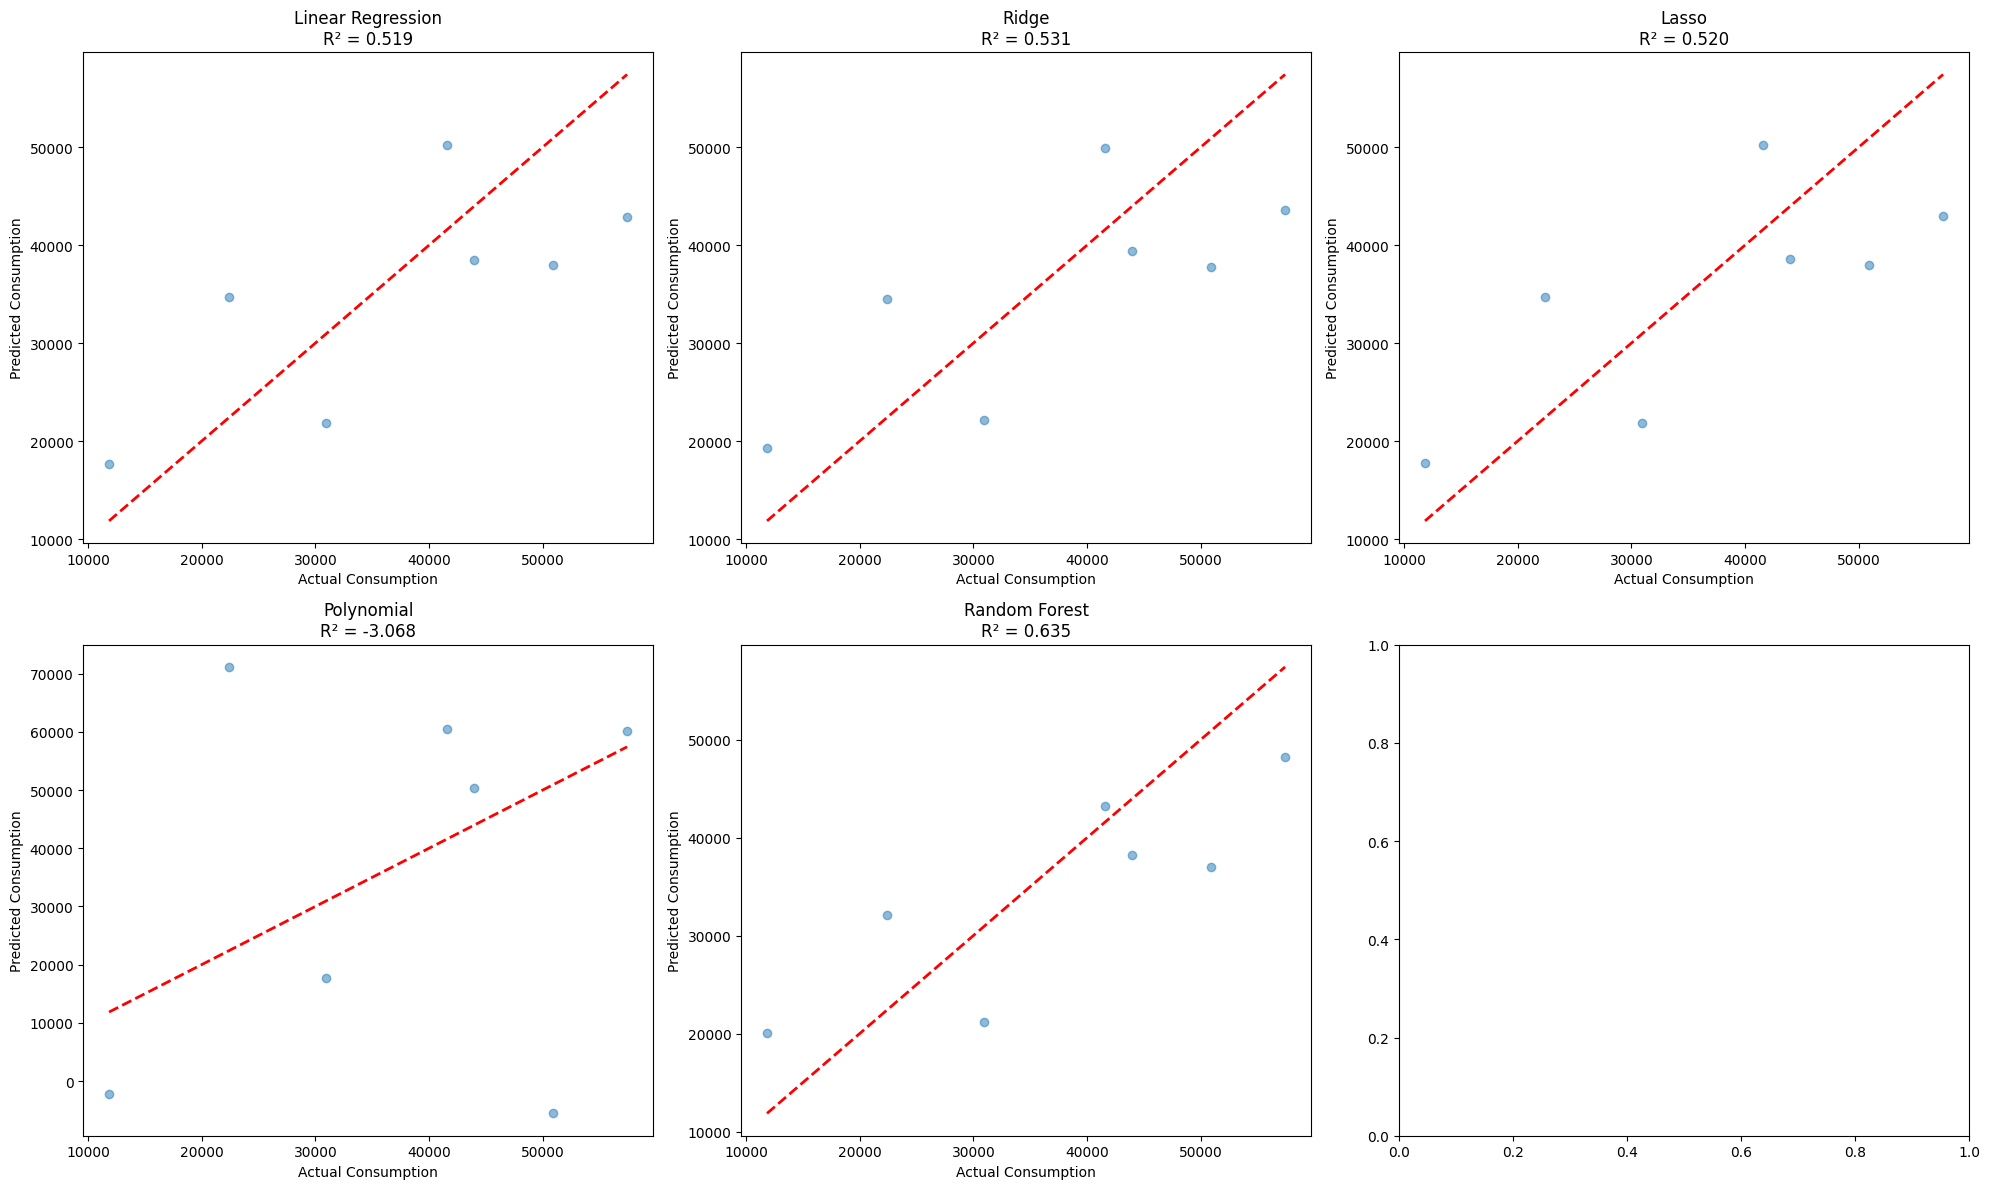

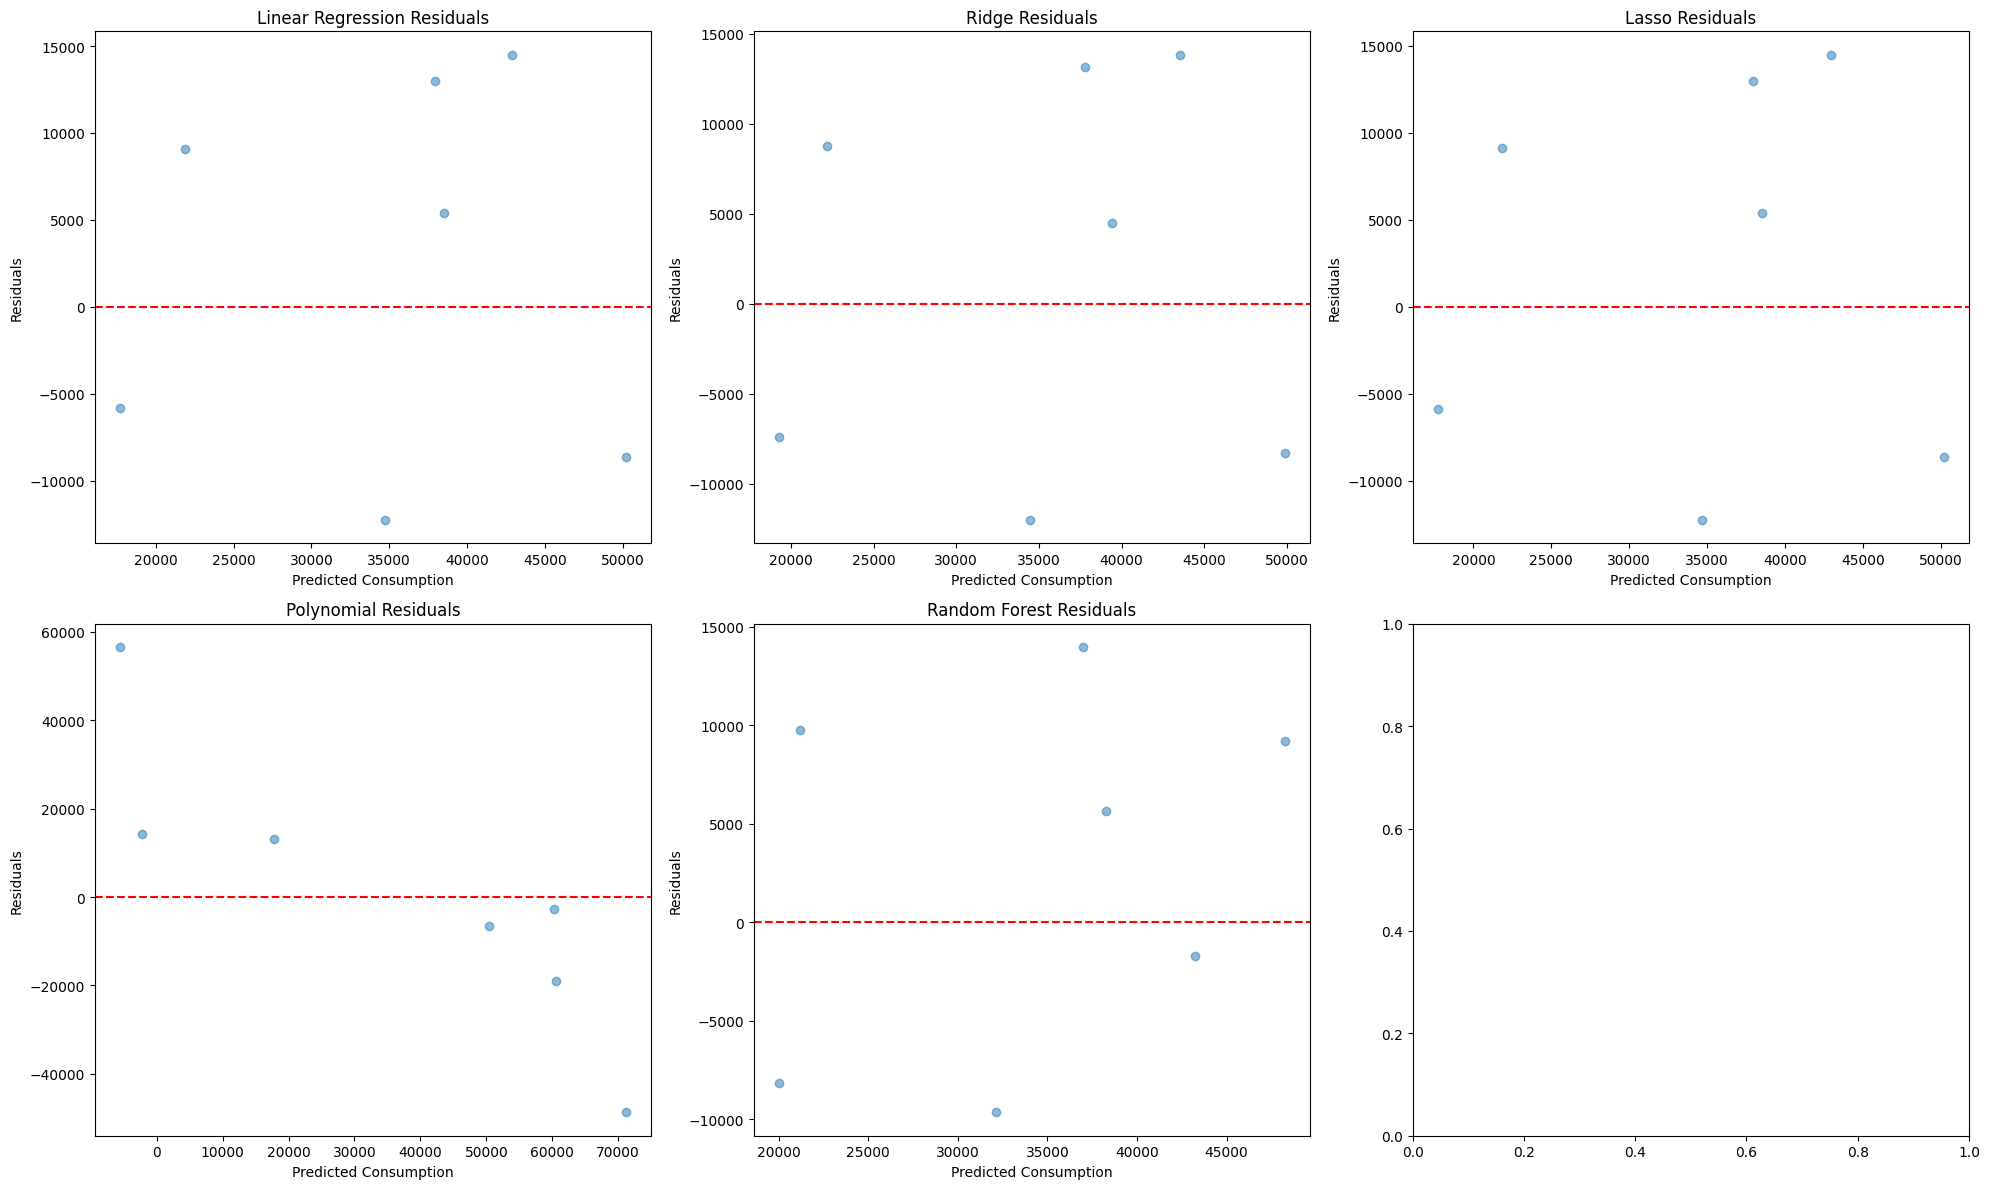

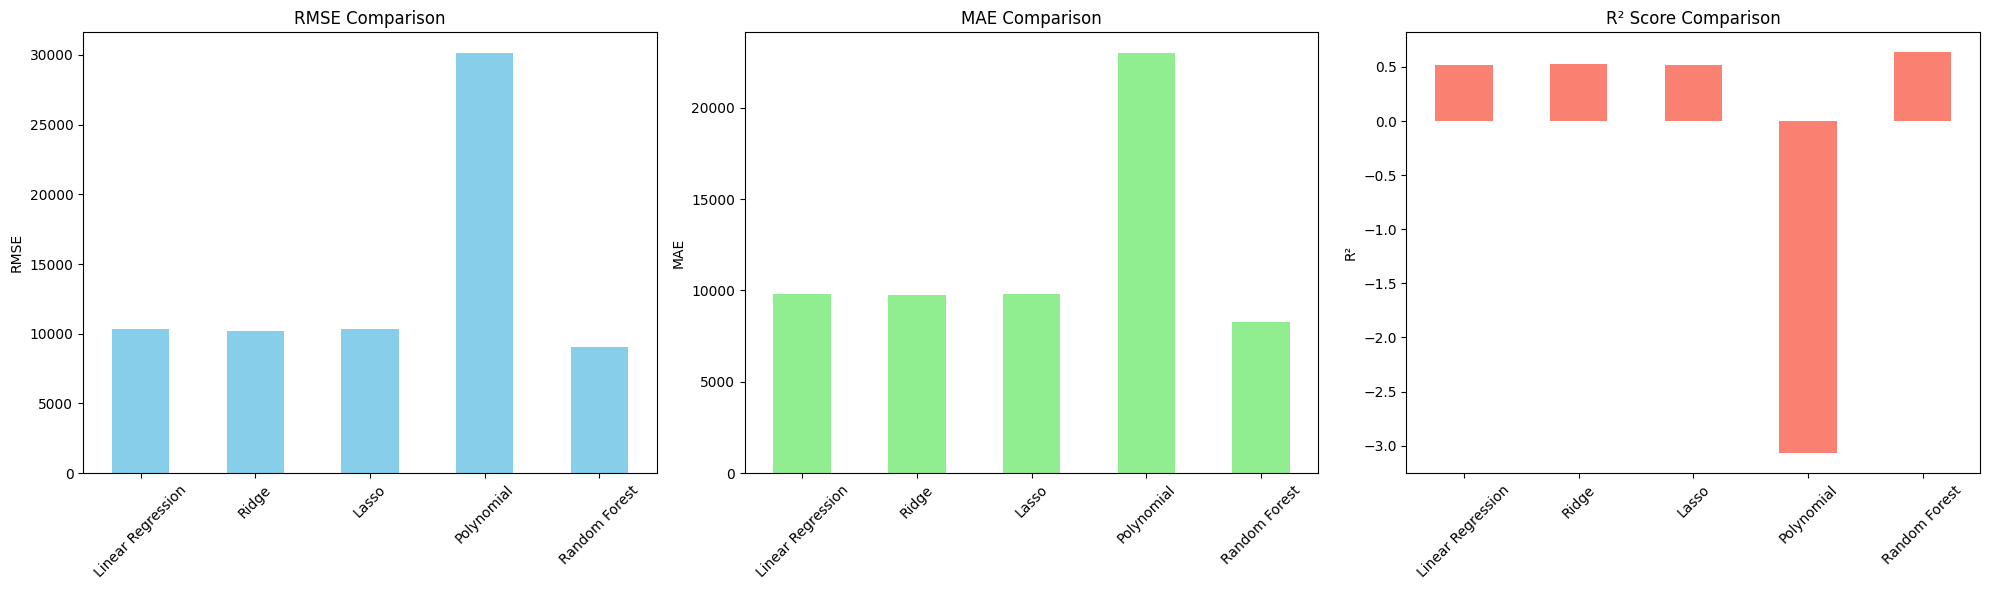

/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_81861/3925635032.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


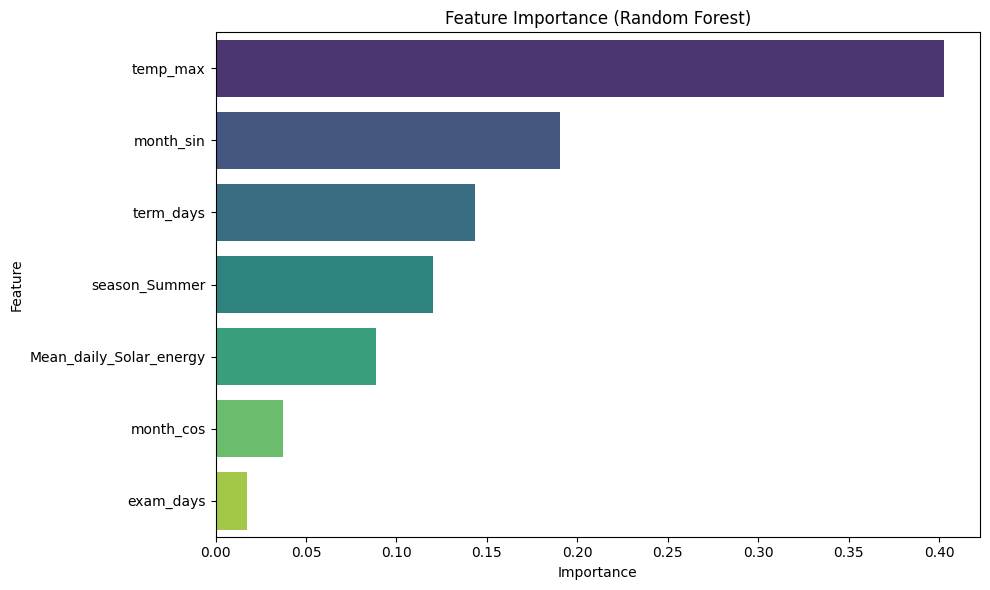

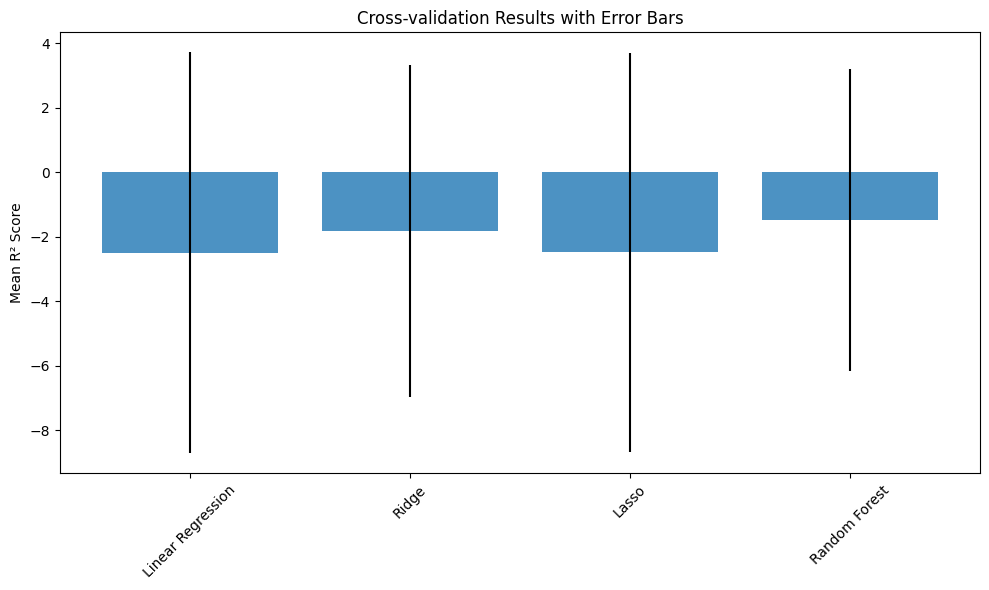

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

# Define selected features based on correlation analysis
final_features = [
    'temp_max',                  # Primary temperature indicator (-0.57)
    'season_Summer',             # Seasonal indicator (-0.59)
    'month_sin', 'month_cos',    # Cyclical components (-0.48, -0.32)
    'Mean_daily_Solar_energy',   # Solar radiation (-0.38)
    'term_days', 'exam_days'     # Operational features (0.22, 0.23)
]

def prepare_data(merged_data):
    """Prepare data for modeling"""
    # First add seasonal features
    data = add_seasonal_features(merged_data.copy())
    
    # Then select features for modeling
    X = data[final_features]
    y = data['consumption']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def add_seasonal_features(df):
    """Add seasonal and cyclical features to the dataframe"""
    # Convert Month to numeric if it's not already
    df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
    
    # Add month-based cyclical features using numpy arrays
    month_values = df['Month'].values  # Convert to numpy array
    df['month_sin'] = np.sin(2 * np.pi * month_values/12)
    df['month_cos'] = np.cos(2 * np.pi * month_values/12)
    
    # Add seasons (Southern Hemisphere)
    conditions = [
        (df['Month'].isin([12, 1, 2])),
        (df['Month'].isin([3, 4, 5])),
        (df['Month'].isin([6, 7, 8])),
        (df['Month'].isin([9, 10, 11]))
    ]
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    df['season'] = np.select(conditions, seasons, default='Unknown')
    
    # Create dummy variables for seasons
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season_dummies], axis=1)
    
    return df

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    return rmse, mae, r2

def train_linear_models(X_train_scaled, X_test_scaled, y_train, y_test):
    """Train and evaluate linear models"""
    models = {}
    metrics = {}
    
    # Multiple Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_test_scaled)
    metrics['Linear Regression'] = evaluate_model(y_test, lr_pred, "Multiple Linear Regression")
    models['Linear Regression'] = lr
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)
    ridge_pred = ridge.predict(X_test_scaled)
    metrics['Ridge'] = evaluate_model(y_test, ridge_pred, "Ridge Regression")
    models['Ridge'] = ridge
    
    # Lasso Regression
    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train_scaled, y_train)
    lasso_pred = lasso.predict(X_test_scaled)
    metrics['Lasso'] = evaluate_model(y_test, lasso_pred, "Lasso Regression")
    models['Lasso'] = lasso
    
    return models, metrics

def train_nonlinear_models(X_train_scaled, X_test_scaled, y_train, y_test):
    """Train and evaluate non-linear models"""
    models = {}
    metrics = {}
    
    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    pr = LinearRegression()
    pr.fit(X_train_poly, y_train)
    pr_pred = pr.predict(X_test_poly)
    metrics['Polynomial'] = evaluate_model(y_test, pr_pred, "Polynomial Regression")
    models['Polynomial'] = (poly, pr)
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    metrics['Random Forest'] = evaluate_model(y_test, rf_pred, "Random Forest")
    models['Random Forest'] = rf
    
    return models, metrics

def perform_cross_validation(X_scaled, y, models):
    """Perform cross-validation for all models"""
    print("\nCross-Validation Results (R² scores):")
    cv_results = {}
    
    for name, model in models.items():
        if name != 'Polynomial':  # Skip polynomial as it needs special handling
            cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
            print(f"{name}: Mean R² = {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            cv_results[name] = cv_scores
    
    return cv_results


def plot_model_performance(models_dict, X_test_scaled, y_test):
    """Plot actual vs predicted values for all models"""
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if name == 'Polynomial':
            poly, model = model
            y_pred = model.predict(poly.transform(X_test_scaled))
        else:
            y_pred = model.predict(X_test_scaled)
        
        # Scatter plot
        axes[idx].scatter(y_test, y_pred, alpha=0.5)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[idx].set_xlabel('Actual Consumption')
        axes[idx].set_ylabel('Predicted Consumption')
        axes[idx].set_title(f'{name}\nR² = {r2_score(y_test, y_pred):.3f}')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(models_dict, X_test_scaled, y_test):
    """Plot residuals for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if name == 'Polynomial':
            poly, model = model
            y_pred = model.predict(poly.transform(X_test_scaled))
        else:
            y_pred = model.predict(X_test_scaled)
        
        residuals = y_test - y_pred
        
        # Residual plot
        axes[idx].scatter(y_pred, residuals, alpha=0.5)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlabel('Predicted Consumption')
        axes[idx].set_ylabel('Residuals')
        axes[idx].set_title(f'{name} Residuals')
    
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(metrics_dict):
    """Plot comparison of model metrics"""
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.columns = ['RMSE', 'MAE', 'R2']
    
    # Create subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot RMSE
    metrics_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    
    # Plot MAE
    metrics_df['MAE'].plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('MAE Comparison')
    axes[1].set_ylabel('MAE')
    
    # Plot R2
    metrics_df['R2'].plot(kind='bar', ax=axes[2], color='salmon')
    axes[2].set_title('R² Score Comparison')
    axes[2].set_ylabel('R²')
    
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(models_dict, feature_names):
    """Plot feature importance for Random Forest model"""
    rf_model = models_dict['Random Forest']
    importance = rf_model.feature_importances_
    
    # Create DataFrame of features and their importance
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

def plot_cv_results(cv_results):
    """Plot cross-validation results"""
    cv_means = {name: scores.mean() for name, scores in cv_results.items()}
    cv_stds = {name: scores.std() * 2 for name, scores in cv_results.items()}
    
    plt.figure(figsize=(10, 6))
    x = range(len(cv_means))
    plt.bar(x, cv_means.values(), yerr=cv_stds.values(), align='center', alpha=0.8)
    plt.xticks(x, cv_means.keys(), rotation=45)
    plt.title('Cross-validation Results with Error Bars')
    plt.ylabel('Mean R² Score')
    plt.tight_layout()
    plt.show()

def main(merged_data):
    # Ensure Month is numeric in merged_data
    if merged_data['Month'].dtype == 'object':
        month_map = {
            'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
        }
        merged_data['Month'] = merged_data['Month'].map(month_map)
    
    # Convert Month to numeric explicitly
    merged_data['Month'] = pd.to_numeric(merged_data['Month'], errors='coerce')
    
    # Prepare data with seasonal features
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(merged_data)
    
    # Train linear models
    print("Training Linear Models...")
    linear_models, linear_metrics = train_linear_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Train non-linear models
    print("\nTraining Non-linear Models...")
    nonlinear_models, nonlinear_metrics = train_nonlinear_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Combine all models and metrics
    all_models = {**linear_models, **nonlinear_models}
    all_metrics = {**linear_metrics, **nonlinear_metrics}
    
    # Combine all models (except Polynomial) for cross-validation
    cv_models = {**linear_models, **{k: v for k, v in nonlinear_models.items() if k != 'Polynomial'}}
    
    # Perform cross-validation
    cv_results = perform_cross_validation(X_train_scaled, y_train, cv_models)
    
    # Create visualizations
    plot_model_performance(all_models, X_test_scaled, y_test)
    plot_residuals(all_models, X_test_scaled, y_test)
    plot_metrics_comparison(all_metrics)
    plot_feature_importance(all_models, final_features)
    plot_cv_results(cv_results)
    
    return linear_models, nonlinear_models, cv_results, all_metrics

if __name__ == "__main__":
    # Run the modeling pipeline with correct unpacking
    linear_models, nonlinear_models, cv_results, metrics = main(merged_data)


In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_enhanced_features(data):
    """Create enhanced feature set based on importance analysis"""
    
    # Select most important features based on Random Forest analysis
    base_features = [
        'temp_max',                  # Most important (0.40)
        'month_sin',                 # Second important (0.20)
        'term_days',                 # Third important (0.15)
        'season_Summer',             # Fourth important (0.15)
        'Mean_daily_Solar_energy'    # Fifth important (0.10)
    ]
    
    # Create interaction terms for important features
    data['temp_max_x_month_sin'] = data['temp_max'] * data['month_sin']
    data['temp_max_x_term_days'] = data['temp_max'] * data['term_days']
    data['temp_max_x_solar'] = data['temp_max'] * data['Mean_daily_Solar_energy']
    
    # Add polynomial terms for temperature and solar features
    #poly = PolynomialFeatures(degree=2, include_bias=False)
    #poly_features = poly.fit_transform(data[['temp_max', 'Mean_daily_Solar_energy']])
    #poly_names = ['temp_max_sq', 'solar_sq', 'temp_solar_interaction']
    
    # Combine all features
    enhanced_features = base_features + [
        'temp_max_x_month_sin',
        'temp_max_x_term_days',
        'temp_max_x_solar'
    ]
    
    return enhanced_features

def train_tuned_rf(X_train, X_test, y_train, y_test):
    """Train Random Forest with hyperparameter tuning"""
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    # Initialize base model
    rf_base = RandomForestRegressor(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_rf = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_rf.predict(X_test)
    
    # Calculate metrics
    results = {
        'best_params': grid_search.best_params_,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }
    
    return best_rf, results

def main(merged_data):
    """Main function for model training and evaluation"""
    # First ensure seasonal features are added
    merged_data = add_seasonal_features(merged_data.copy())
    
    # Then prepare enhanced features list
    enhanced_features = prepare_enhanced_features(merged_data)
    
    # Prepare data for modeling
    X = merged_data[enhanced_features]
    y = merged_data['consumption']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate model
    best_model, results = train_tuned_rf(X_train_scaled, X_test_scaled, y_train, y_test)
    
    return best_model, results

if __name__ == "__main__":
    best_model, results = main(merged_data)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [51]:
best_model

RandomForestRegressor(max_depth=20, max_features='log2', random_state=42)

In [52]:
results

{'best_params': {'max_depth': 20,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'rmse': np.float64(8800.420937555724),
 'mae': 7946.919885714275,
 'r2': 0.6526013198856343}

Now for the Data ECCLES GREAT KING STREET,UNIVERSITY OF

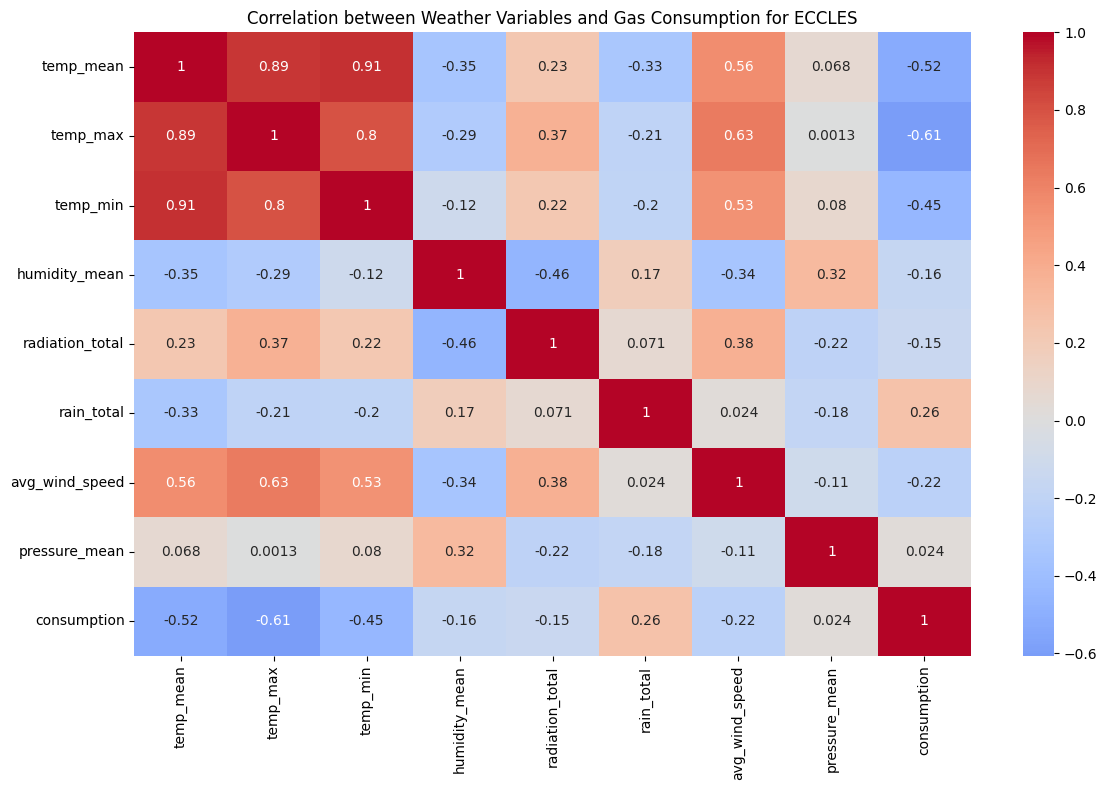


Statistical Summary:

Weather Data Statistics:
       temp_mean   temp_max   temp_min  humidity_mean  radiation_total  \
count  35.000000  35.000000  35.000000      35.000000     3.500000e+01   
mean   13.544382  23.422000   5.062343      64.320709     3.061542e+06   
std     3.010834   4.124962   3.703987       4.248893     2.652652e+06   
min     8.767209  16.590000  -1.100000      55.371280     3.988578e+05   
25%    10.759897  20.225000   1.671000      61.251928     1.007929e+06   
50%    13.596058  23.100000   5.352000      64.395338     1.822046e+06   
75%    16.153294  26.100000   8.790000      67.307034     5.058180e+06   
max    19.141647  31.100000  12.500000      71.850689     8.258166e+06   

       rain_total  avg_wind_speed  pressure_mean  
count   35.000000       35.000000      35.000000  
mean    25.314286        3.359062    1008.573380  
std     23.224494        0.499098       3.468777  
min      3.800000        1.847772    1000.981267  
25%     14.100000        3.067

In [55]:
BASE_DIR = Path(os.getcwd()).parents[2] 
WEATHER_PATH = BASE_DIR / "backend/data/Weather/Load_weather_monthly.csv"

# Read the CSV files
weather_df = pd.read_csv(WEATHER_PATH)
gas_df = df_eccles

weather_df['Month'] = weather_df['Month'].astype(str).str.zfill(2)
    
# Create date column for proper merging
weather_df['date'] = pd.to_datetime(weather_df['Year'].astype(str) + '-' + weather_df['Month'].astype(str) + '-01')

# Melt gas data
gas_melted = pd.melt(gas_df, 
                    id_vars=['meter_description'],
                    var_name='date',
                    value_name='consumption')

# Convert gas data date format
gas_melted['date'] = pd.to_datetime(gas_melted['date'], format='%b_%Y')

# Group gas data by date
gas_grouped = gas_melted.groupby('date')['consumption'].sum().reset_index()

# Merge weather and gas data
merged_data = pd.merge(weather_df, gas_grouped, on='date')

# Select relevant weather variables for correlation
weather_vars = ['temp_mean', 'temp_max', 'temp_min', 'humidity_mean', 
                'radiation_total', 'rain_total', 'avg_wind_speed', 'pressure_mean']

# Calculate correlation matrix
correlation_matrix = merged_data[weather_vars + ['consumption']].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Gas Consumption for ECCLES')
plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
print("\nWeather Data Statistics:")
print(merged_data[weather_vars].describe())

print("\nGas Consumption Statistics:")
print(merged_data['consumption'].describe())

# Calculate specific correlations with consumption
correlations = correlation_matrix['consumption'].sort_values(ascending=False)
print("\nCorrelations with Gas Consumption:")
print(correlations)

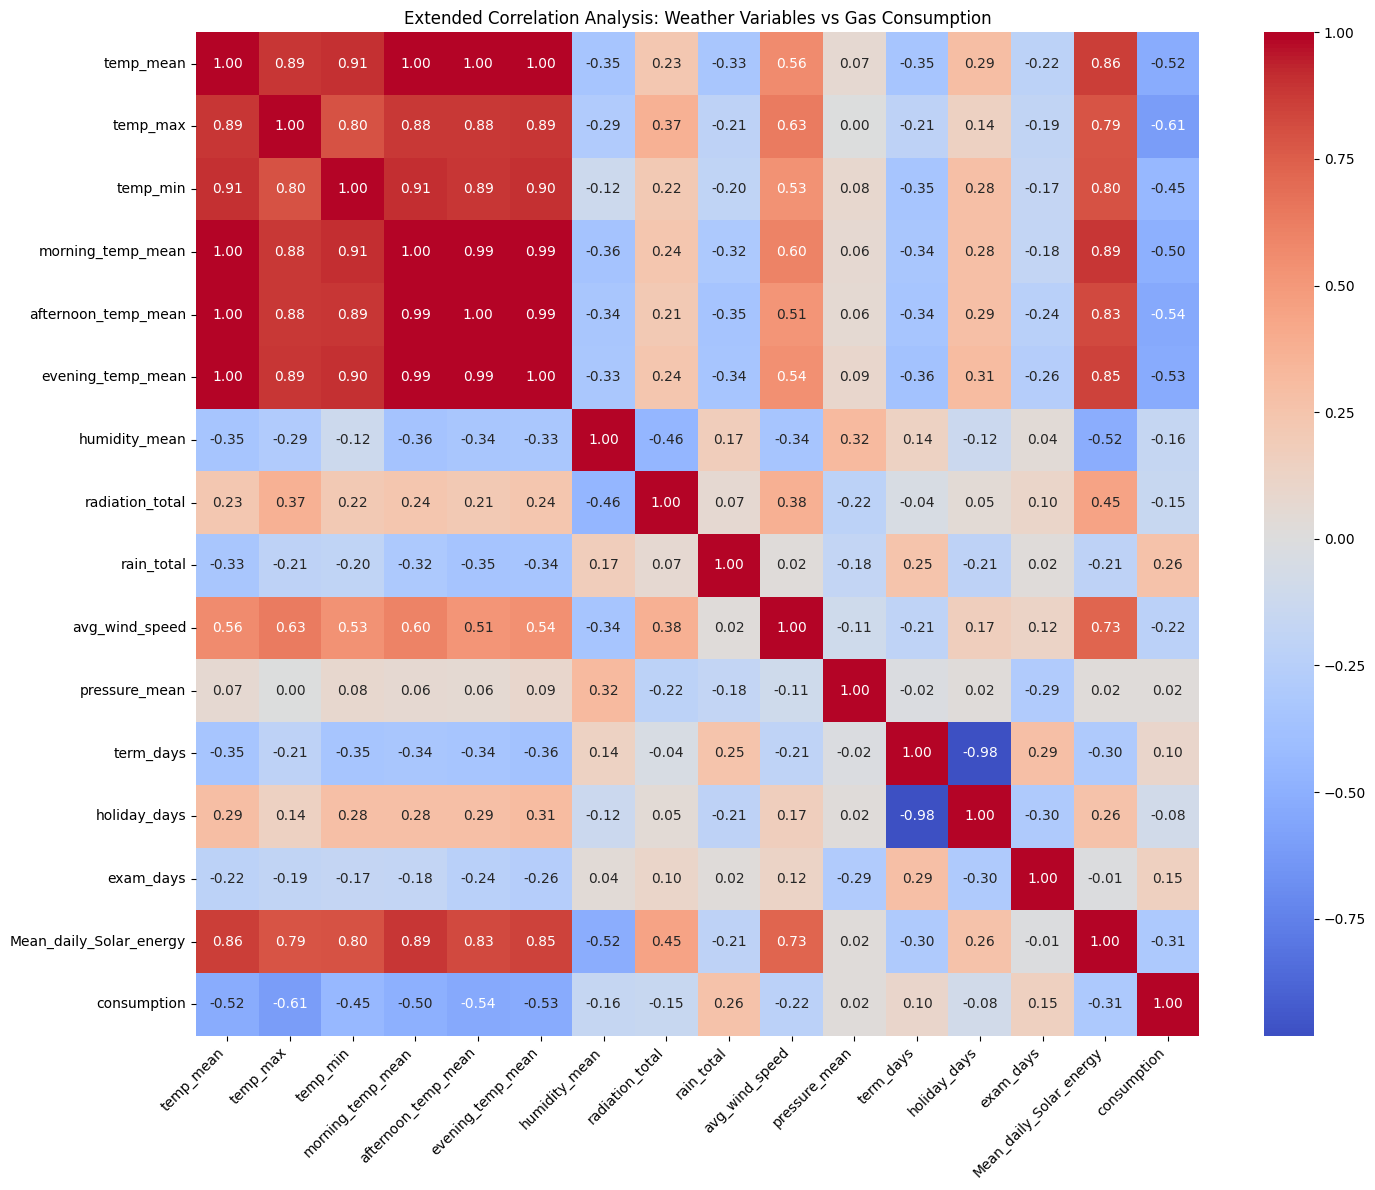

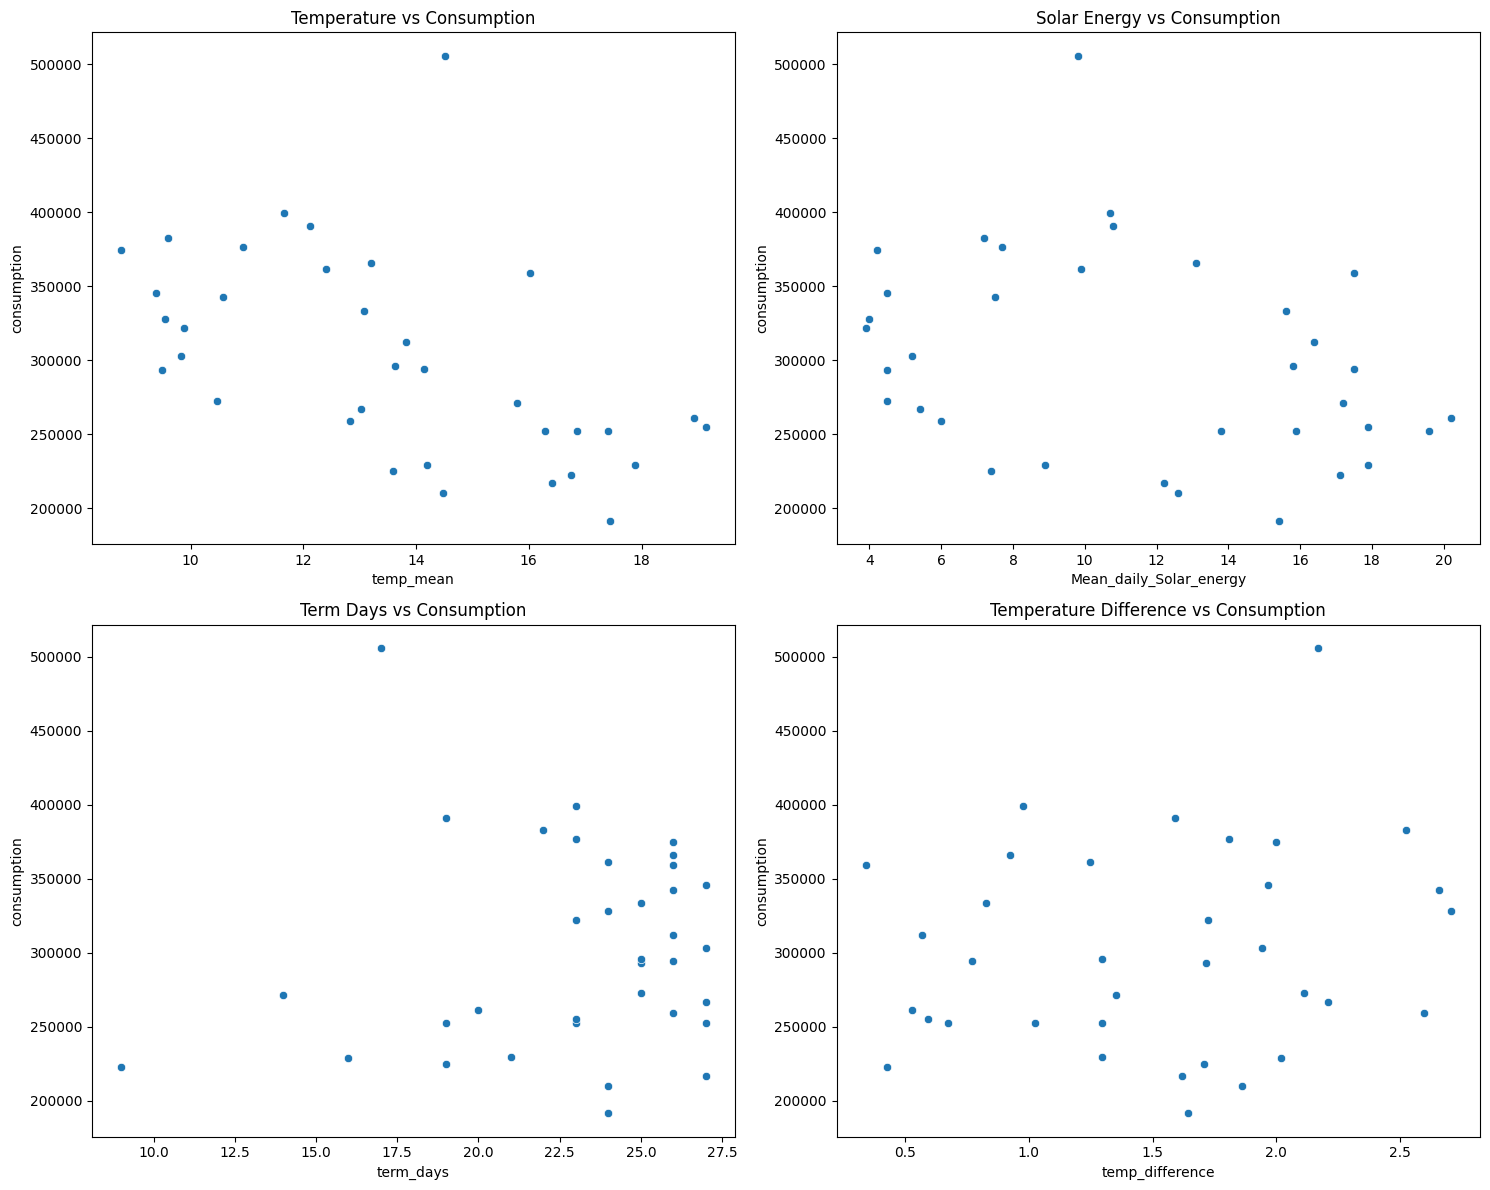

In [54]:
correlation_matrix = analyze_extended_correlations(merged_data)

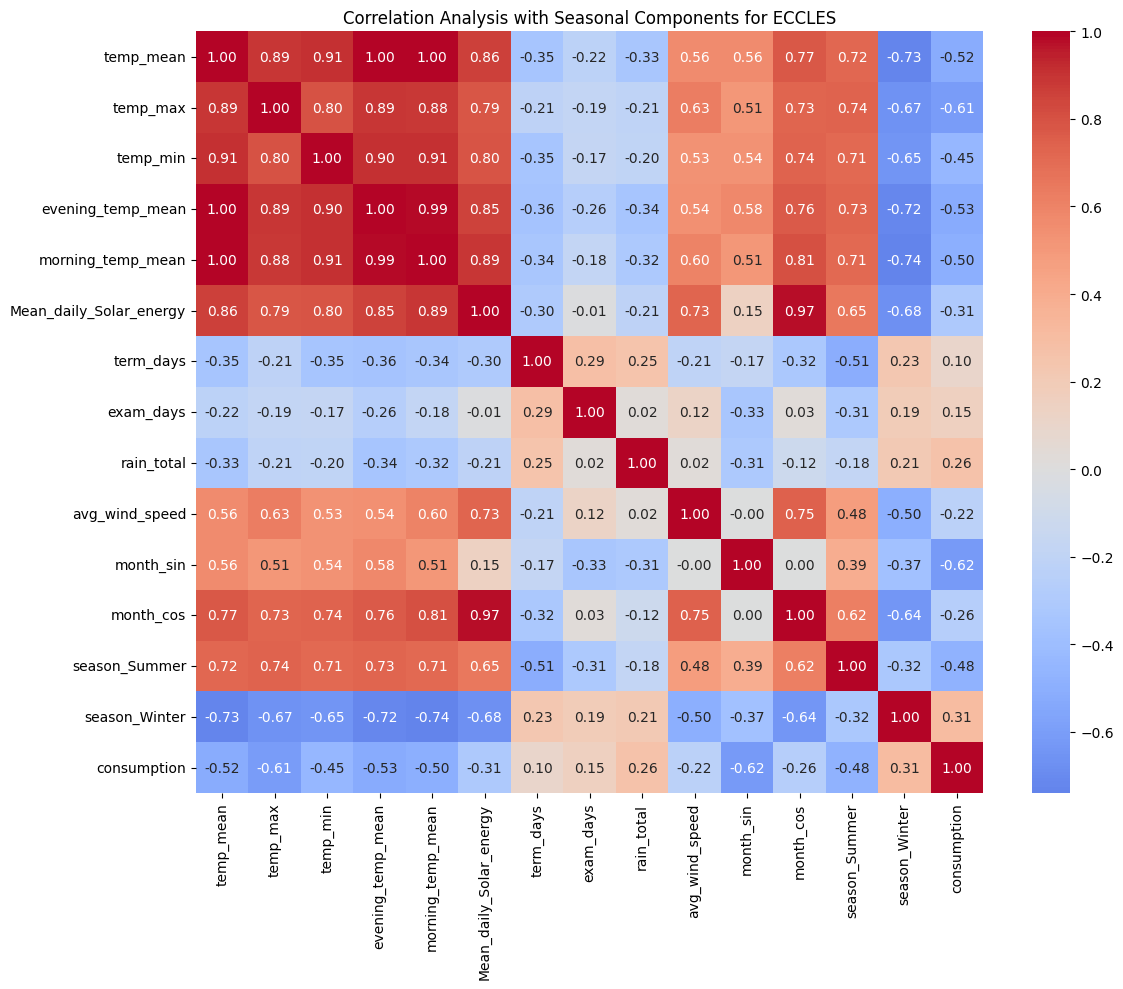

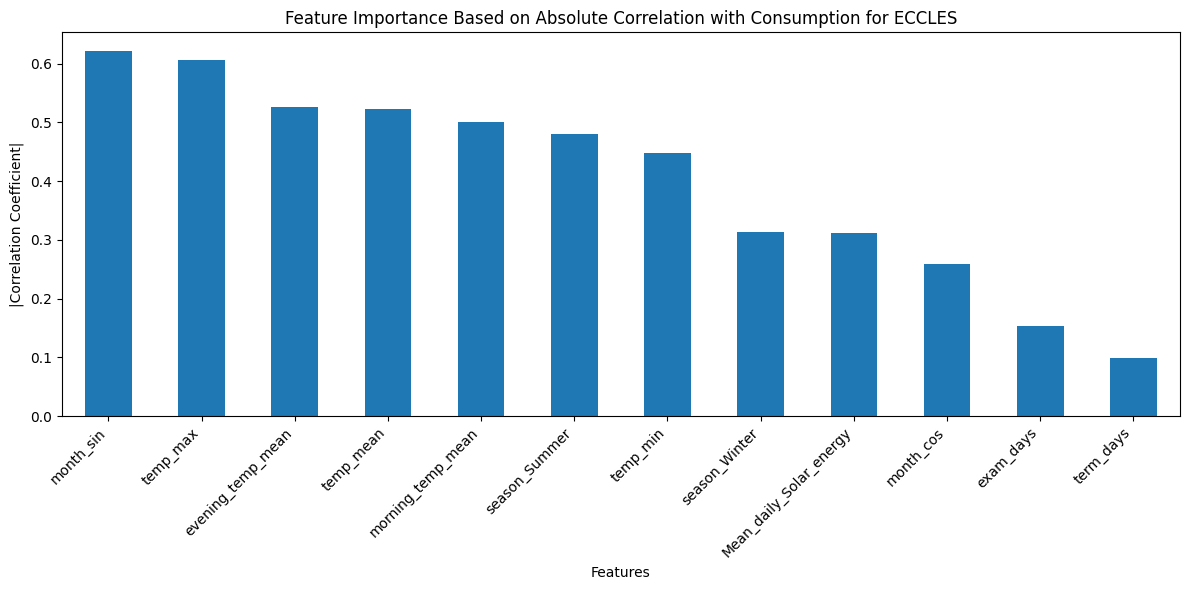


Feature Importance Ranking:
month_sin                  0.622026
temp_max                   0.606002
evening_temp_mean          0.526198
temp_mean                  0.522216
morning_temp_mean          0.500992
season_Summer              0.479646
temp_min                   0.446953
season_Winter              0.313141
Mean_daily_Solar_energy    0.310880
month_cos                  0.259146
exam_days                  0.152573
term_days                  0.098164
Name: consumption, dtype: float64


In [57]:
#ECCLES
# 
# 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def add_seasonal_features(df):
    """Add seasonal and cyclical features to the dataframe"""
    # Add month-based cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    
    # Add seasons (Southern Hemisphere)
    conditions = [
        (df['Month'].isin([12, 1, 2])),
        (df['Month'].isin([3, 4, 5])),
        (df['Month'].isin([6, 7, 8])),
        (df['Month'].isin([9, 10, 11]))
    ]
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    df['season'] = np.select(conditions, seasons, default='Unknown')
    
    # Create dummy variables for seasons
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season_dummies], axis=1)
    
    return df

def analyze_correlations(merged_data):
    """Analyze and visualize correlations with seasonal components"""
    # Select relevant features
    features = [
        'temp_mean', 'temp_max', 'temp_min',
        'evening_temp_mean', 'morning_temp_mean',
        'Mean_daily_Solar_energy',
        'term_days', 'exam_days','rain_total','avg_wind_speed',
        'month_sin', 'month_cos',
        'season_Summer', 'season_Winter',
        'consumption'
    ]
    
    # Calculate correlation matrix
    correlation_matrix = merged_data[features].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f')
    plt.title('Correlation Analysis with Seasonal Components for ECCLES')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix


def analyze_feature_importance(merged_data):
    """Analyze feature importance based on correlation with consumption"""
    
    # Select features that exist in the dataset before seasonal transformations
    basic_features = [
        'temp_max',           
        'evening_temp_mean',  
        'temp_min',          
        'temp_mean',         
        'morning_temp_mean', 
        'Mean_daily_Solar_energy',
        'term_days',         
        'exam_days'          
    ]
    
    # Add seasonal features if they exist
    all_features = basic_features.copy()
    seasonal_features = ['month_sin', 'month_cos', 'season_Summer', 'season_Winter']
    
    for feature in seasonal_features:
        if feature in merged_data.columns:
            all_features.append(feature)
    
    # Calculate absolute correlations with consumption
    correlations = merged_data[all_features + ['consumption']].corr()['consumption'].abs()
    
    # Sort features by absolute correlation value
    feature_importance = correlations[:-1].sort_values(ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance Based on Absolute Correlation with Consumption for ECCLES')
    plt.xlabel('Features')
    plt.ylabel('|Correlation Coefficient|')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def main():
    # Load and prepare data
    BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
    WEATHER_PATH = BASE_DIR / "backend/data/Weather/Load_weather_monthly.csv"
    METER_PATH = BASE_DIR / "backend/data/Cleaned/gas_automated_meter_cleaned.csv"

    weather_df = pd.read_csv(WEATHER_PATH)
    gas_df = pd.read_csv(METER_PATH)
    
    # Remove ECCLES building
    gas_df = gas_df[gas_df['meter_description'] == 'ECCLES GREAT KING STREET,UNIVERSITY OF']
    
    # Prepare gas consumption data
    gas_melted = pd.melt(gas_df, 
                        id_vars=['meter_description'],
                        var_name='date',
                        value_name='consumption')
    gas_melted['date'] = pd.to_datetime(gas_melted['date'], format='%b_%Y')
    gas_melted['Year'] = gas_melted['date'].dt.year
    gas_melted['Month'] = gas_melted['date'].dt.month
    
    # Convert month names to numbers in weather_df if needed
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    
    # Check if Month is string and needs conversion
    if weather_df['Month'].dtype == 'object':
        weather_df['Month'] = weather_df['Month'].map(month_map)
    
    weather_df['Year'] = weather_df['Year'].astype(int)
    gas_melted['Month'] = gas_melted['Month'].astype(int)
    gas_melted['Year'] = gas_melted['Year'].astype(int)
    
    # Group gas data
    gas_grouped = gas_melted.groupby(['Year', 'Month'])['consumption'].sum().reset_index()
    
    # Merge weather and gas data
    merged_data = pd.merge(weather_df, gas_grouped, on=['Year', 'Month'])
    
    # Add seasonal features
    merged_data = add_seasonal_features(merged_data)
    
    # Analyze correlations
    correlation_matrix = analyze_correlations(merged_data)
    
    # Then analyze feature importance
    feature_importance = analyze_feature_importance(merged_data)
    
    print("\nFeature Importance Ranking:")
    print(feature_importance)
    
    return correlation_matrix, feature_importance

if __name__ == "__main__":
    correlation_matrix, feature_importance = main()


Training Linear Models...

Multiple Linear Regression Performance Metrics for ECCLES:
RMSE: 54236.86
MAE: 41844.99
R2 Score: 0.1058

Ridge Regression Performance Metrics for ECCLES:
RMSE: 51866.82
MAE: 39100.81
R2 Score: 0.1823

Lasso Regression Performance Metrics for ECCLES:
RMSE: 54234.19
MAE: 41841.83
R2 Score: 0.1059

Training Non-linear Models...

Polynomial Regression Performance Metrics for ECCLES:
RMSE: 54673.78
MAE: 44657.42
R2 Score: 0.0914

Random Forest Performance Metrics for ECCLES:
RMSE: 51444.03
MAE: 38936.30
R2 Score: 0.1955

Cross-Validation Results (R² scores) for ECCLES:
Linear Regression: Mean R² = -1.6636 (+/- 7.5949)
Ridge: Mean R² = -1.3340 (+/- 6.5437)
Lasso: Mean R² = -1.6635 (+/- 7.5946)
Random Forest: Mean R² = -0.3236 (+/- 3.1846)


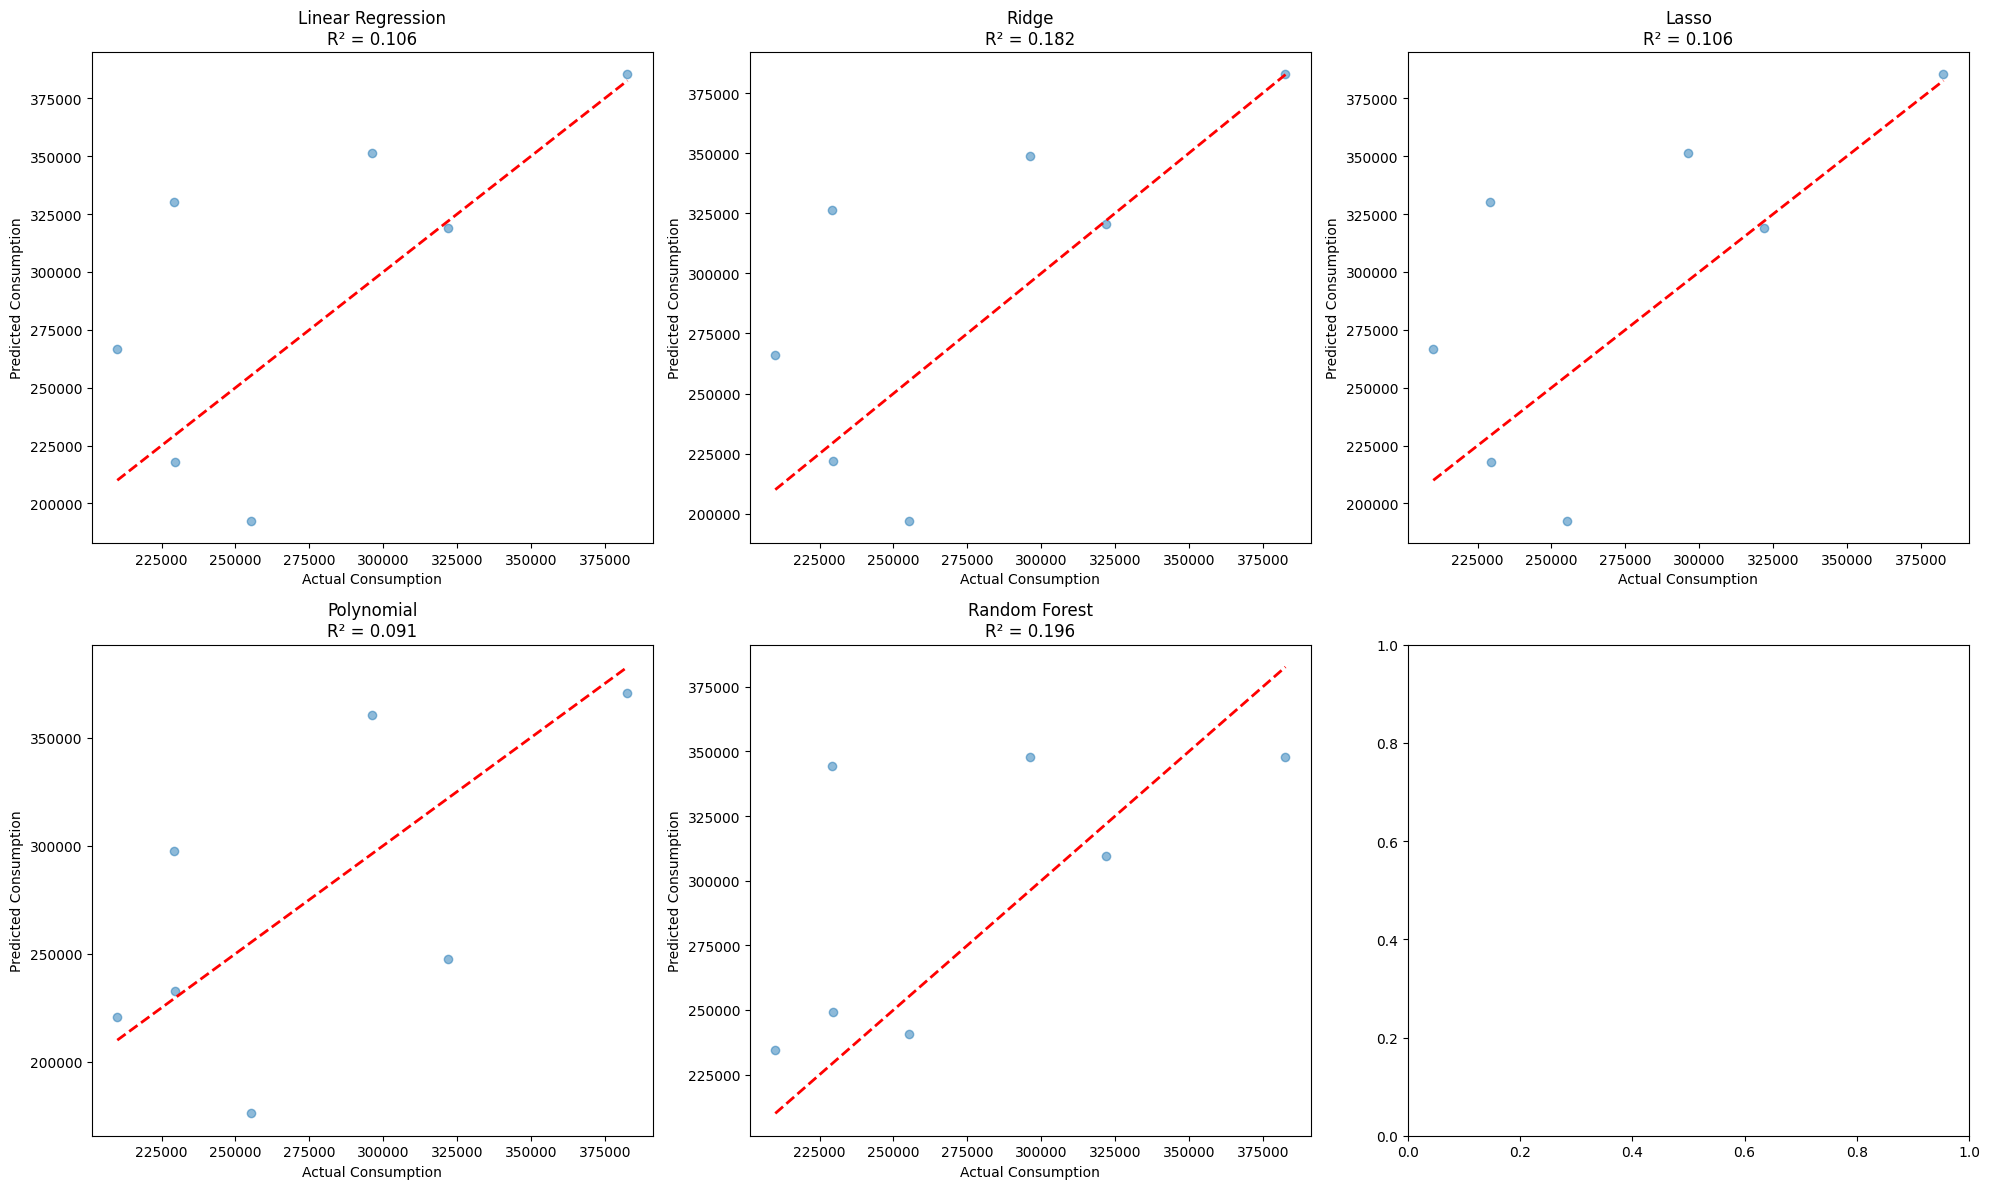

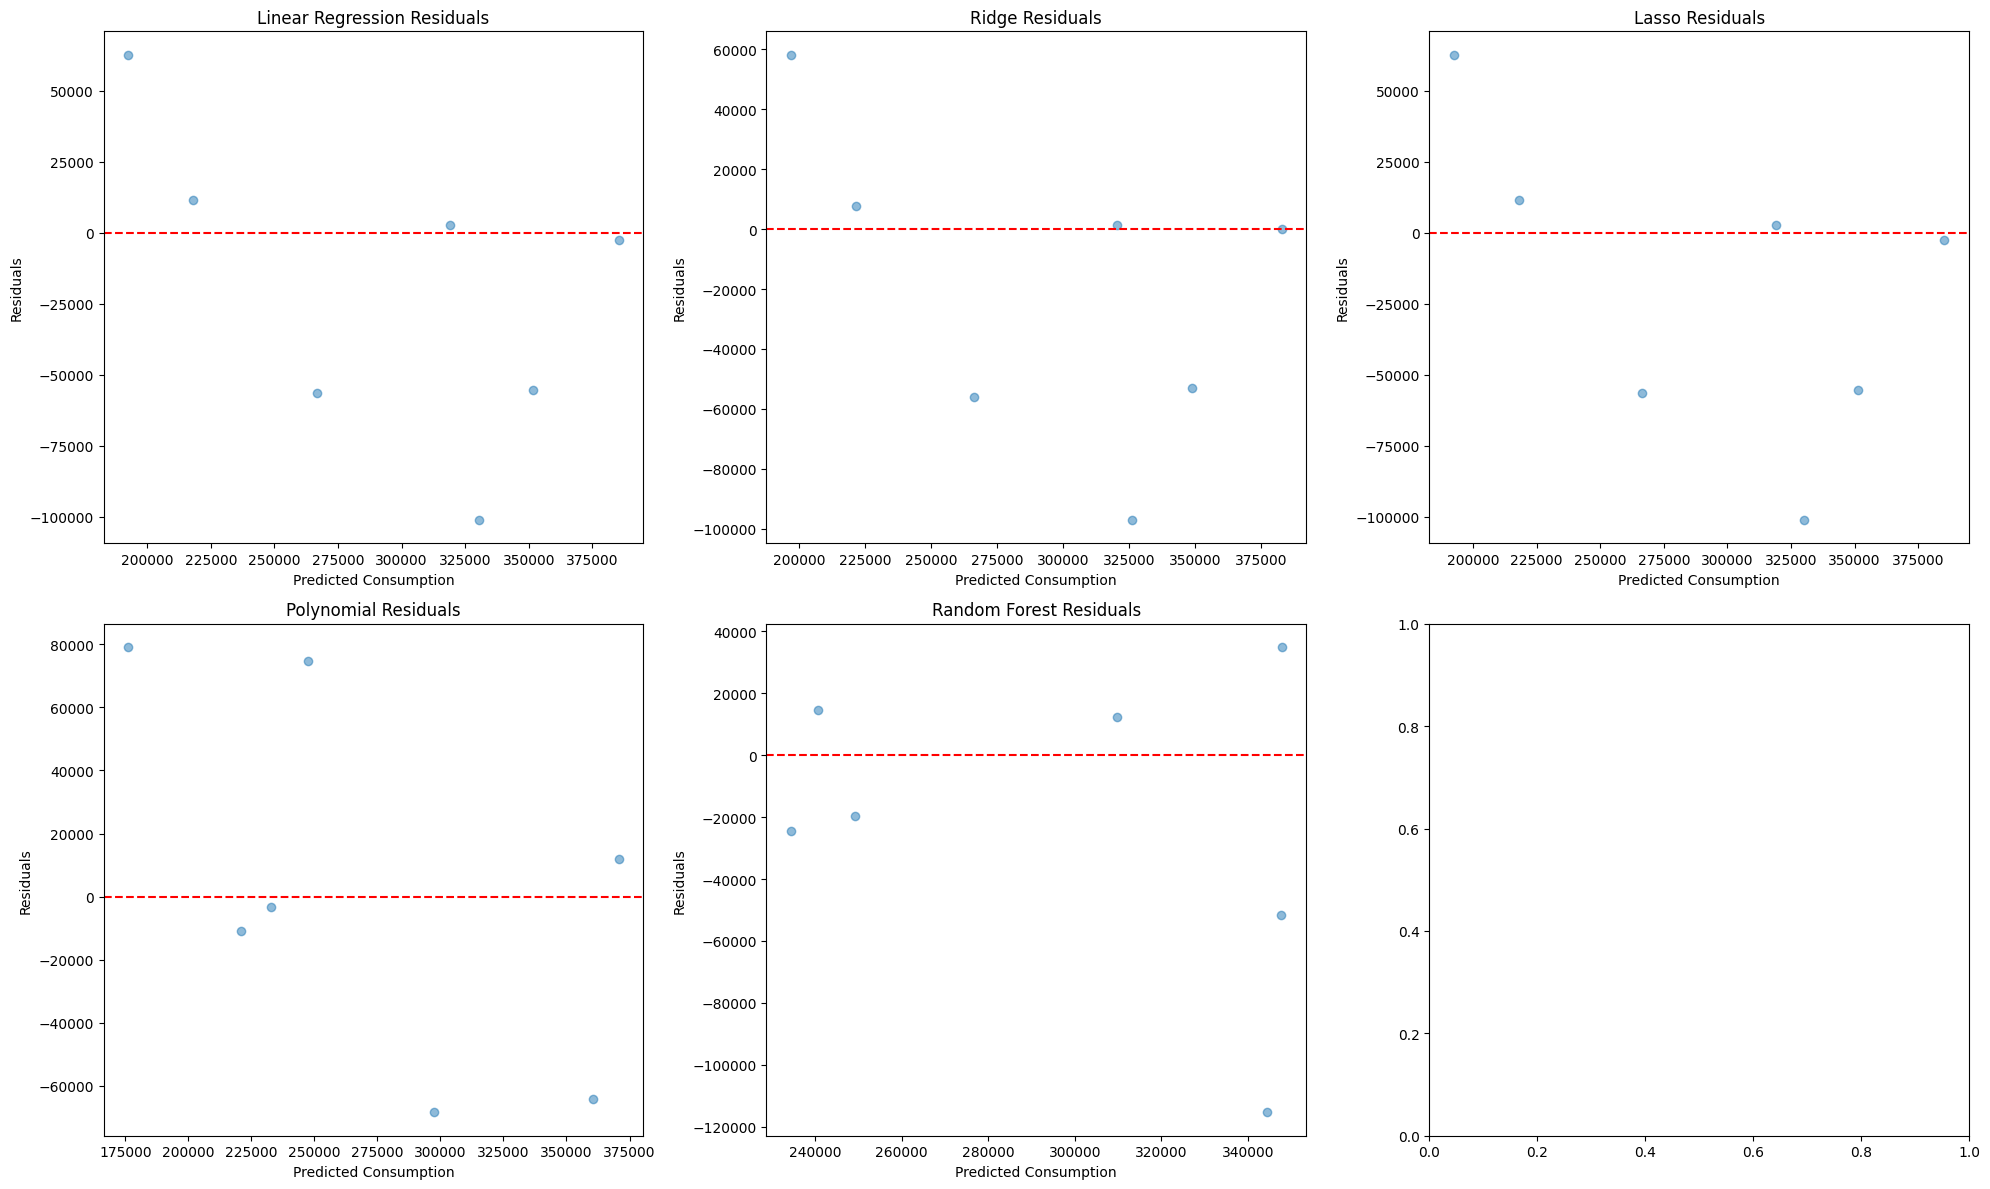

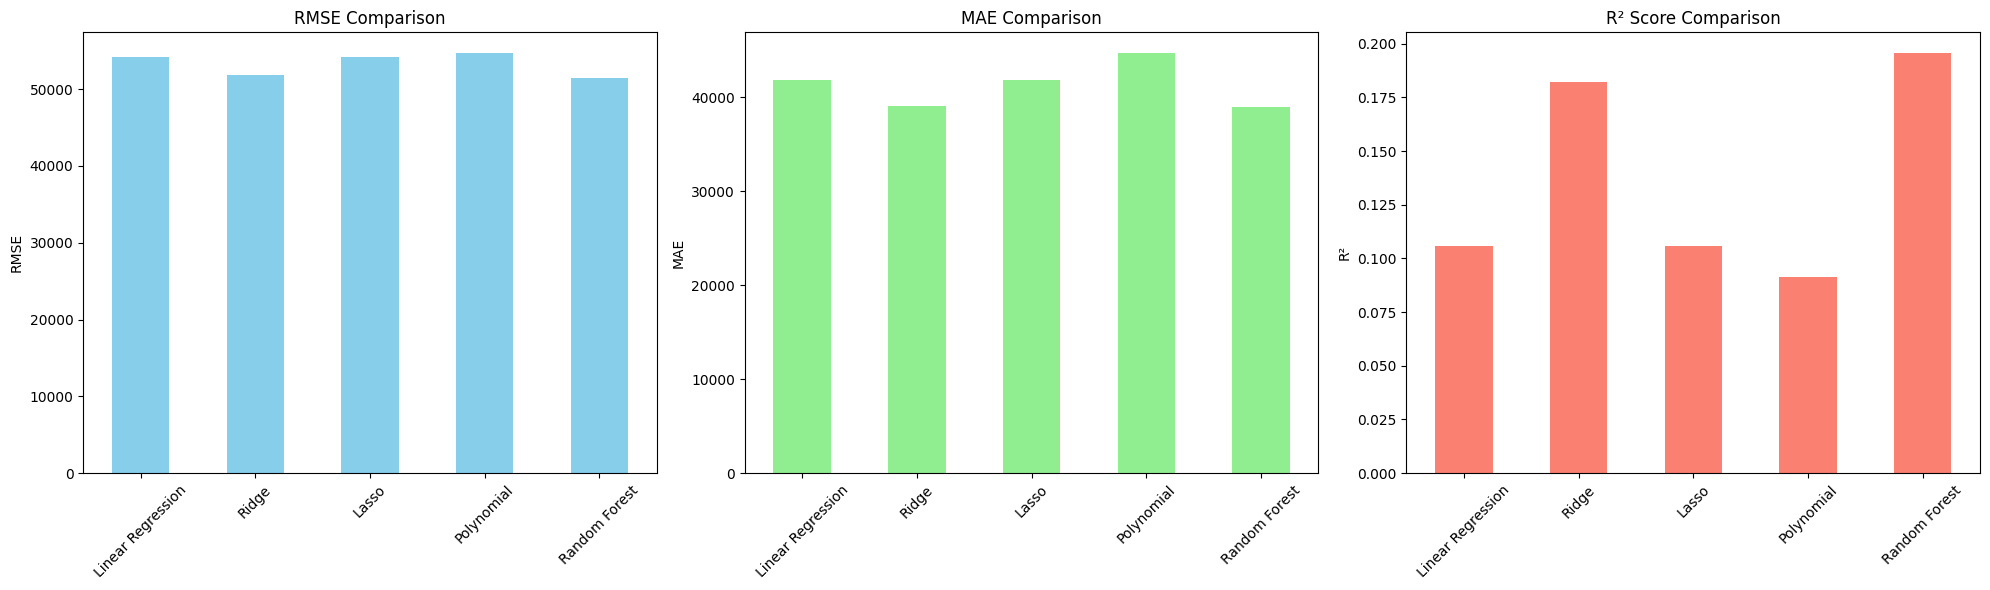

/var/folders/58/qxt37p251zn90grr221ql66m0000gn/T/ipykernel_81861/1150957728.py:238: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


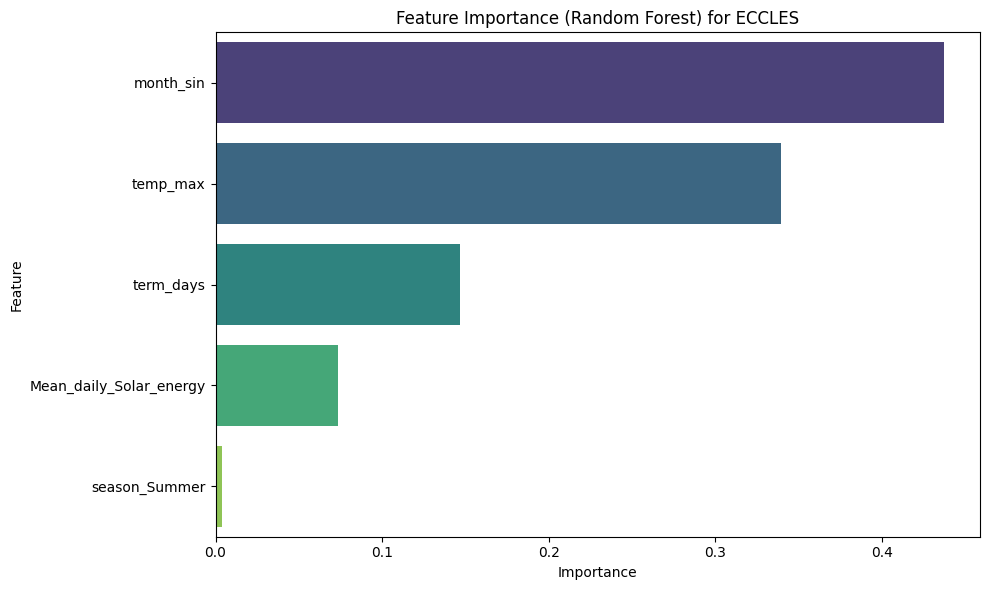

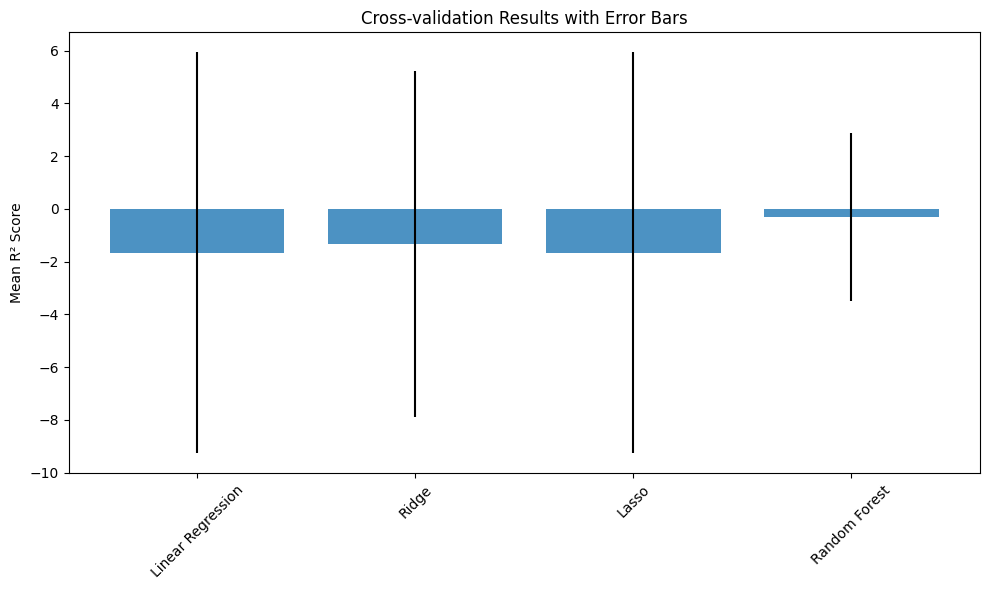

In [60]:
#ECCLES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

# Define selected features based on correlation analysis
final_features = [
    'temp_max',                  # Strong correlation (0.61)
    'month_sin',                 # Strongest correlation (0.62)
    'season_Summer',             # Moderate correlation (0.48)
    'Mean_daily_Solar_energy',   # Moderate correlation (0.31)
    'term_days'                  # Weak but relevant (0.10)
]

def prepare_data(merged_data):
    """Prepare data for modeling"""
    # First add seasonal features
    data = add_seasonal_features(merged_data.copy())
    
    # Then select features for modeling
    X = data[final_features]
    y = data['consumption']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def add_seasonal_features(df):
    """Add seasonal and cyclical features to the dataframe"""
    # Convert Month to numeric if it's not already
    df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
    
    # Add month-based cyclical features using numpy arrays
    month_values = df['Month'].values  # Convert to numpy array
    df['month_sin'] = np.sin(2 * np.pi * month_values/12)
    df['month_cos'] = np.cos(2 * np.pi * month_values/12)
    
    # Add seasons (Southern Hemisphere)
    conditions = [
        (df['Month'].isin([12, 1, 2])),
        (df['Month'].isin([3, 4, 5])),
        (df['Month'].isin([6, 7, 8])),
        (df['Month'].isin([9, 10, 11]))
    ]
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    df['season'] = np.select(conditions, seasons, default='Unknown')
    
    # Create dummy variables for seasons
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season_dummies], axis=1)
    
    return df

def evaluate_model(y_true, y_pred, model_name):
    """Calculate and print evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance Metrics for ECCLES:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    return rmse, mae, r2

def train_linear_models(X_train_scaled, X_test_scaled, y_train, y_test):
    """Train and evaluate linear models"""
    models = {}
    metrics = {}
    
    # Multiple Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_test_scaled)
    metrics['Linear Regression'] = evaluate_model(y_test, lr_pred, "Multiple Linear Regression")
    models['Linear Regression'] = lr
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)
    ridge_pred = ridge.predict(X_test_scaled)
    metrics['Ridge'] = evaluate_model(y_test, ridge_pred, "Ridge Regression")
    models['Ridge'] = ridge
    
    # Lasso Regression
    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train_scaled, y_train)
    lasso_pred = lasso.predict(X_test_scaled)
    metrics['Lasso'] = evaluate_model(y_test, lasso_pred, "Lasso Regression")
    models['Lasso'] = lasso
    
    return models, metrics

def train_nonlinear_models(X_train_scaled, X_test_scaled, y_train, y_test):
    """Train and evaluate non-linear models"""
    models = {}
    metrics = {}
    
    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    pr = LinearRegression()
    pr.fit(X_train_poly, y_train)
    pr_pred = pr.predict(X_test_poly)
    metrics['Polynomial'] = evaluate_model(y_test, pr_pred, "Polynomial Regression")
    models['Polynomial'] = (poly, pr)
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    metrics['Random Forest'] = evaluate_model(y_test, rf_pred, "Random Forest")
    models['Random Forest'] = rf
    
    return models, metrics

def perform_cross_validation(X_scaled, y, models):
    """Perform cross-validation for all models"""
    print("\nCross-Validation Results (R² scores) for ECCLES:")
    cv_results = {}
    
    for name, model in models.items():
        if name != 'Polynomial':  # Skip polynomial as it needs special handling
            cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
            print(f"{name}: Mean R² = {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
            cv_results[name] = cv_scores
    
    return cv_results


def plot_model_performance(models_dict, X_test_scaled, y_test):
    """Plot actual vs predicted values for all models"""
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if name == 'Polynomial':
            poly, model = model
            y_pred = model.predict(poly.transform(X_test_scaled))
        else:
            y_pred = model.predict(X_test_scaled)
        
        # Scatter plot
        axes[idx].scatter(y_test, y_pred, alpha=0.5)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[idx].set_xlabel('Actual Consumption')
        axes[idx].set_ylabel('Predicted Consumption')
        axes[idx].set_title(f'{name}\nR² = {r2_score(y_test, y_pred):.3f}')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(models_dict, X_test_scaled, y_test):
    """Plot residuals for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if name == 'Polynomial':
            poly, model = model
            y_pred = model.predict(poly.transform(X_test_scaled))
        else:
            y_pred = model.predict(X_test_scaled)
        
        residuals = y_test - y_pred
        
        # Residual plot
        axes[idx].scatter(y_pred, residuals, alpha=0.5)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlabel('Predicted Consumption')
        axes[idx].set_ylabel('Residuals')
        axes[idx].set_title(f'{name} Residuals')
    
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(metrics_dict):
    """Plot comparison of model metrics"""
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.columns = ['RMSE', 'MAE', 'R2']
    
    # Create subplots for each metric
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot RMSE
    metrics_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    
    # Plot MAE
    metrics_df['MAE'].plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('MAE Comparison')
    axes[1].set_ylabel('MAE')
    
    # Plot R2
    metrics_df['R2'].plot(kind='bar', ax=axes[2], color='salmon')
    axes[2].set_title('R² Score Comparison')
    axes[2].set_ylabel('R²')
    
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(models_dict, feature_names):
    """Plot feature importance for Random Forest model"""
    rf_model = models_dict['Random Forest']
    importance = rf_model.feature_importances_
    
    # Create DataFrame of features and their importance
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title('Feature Importance (Random Forest) for ECCLES')
    plt.tight_layout()
    plt.show()

def plot_cv_results(cv_results):
    """Plot cross-validation results"""
    cv_means = {name: scores.mean() for name, scores in cv_results.items()}
    cv_stds = {name: scores.std() * 2 for name, scores in cv_results.items()}
    
    plt.figure(figsize=(10, 6))
    x = range(len(cv_means))
    plt.bar(x, cv_means.values(), yerr=cv_stds.values(), align='center', alpha=0.8)
    plt.xticks(x, cv_means.keys(), rotation=45)
    plt.title('Cross-validation Results with Error Bars')
    plt.ylabel('Mean R² Score')
    plt.tight_layout()
    plt.show()

def main(merged_data):
    # Ensure Month is numeric in merged_data
    if merged_data['Month'].dtype == 'object':
        month_map = {
            'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
            'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
        }
        merged_data['Month'] = merged_data['Month'].map(month_map)
    
    # Convert Month to numeric explicitly
    merged_data['Month'] = pd.to_numeric(merged_data['Month'], errors='coerce')
    
    # Prepare data with seasonal features
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(merged_data)
    
    # Train linear models
    print("Training Linear Models...")
    linear_models, linear_metrics = train_linear_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Train non-linear models
    print("\nTraining Non-linear Models...")
    nonlinear_models, nonlinear_metrics = train_nonlinear_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Combine all models and metrics
    all_models = {**linear_models, **nonlinear_models}
    all_metrics = {**linear_metrics, **nonlinear_metrics}
    
    # Combine all models (except Polynomial) for cross-validation
    cv_models = {**linear_models, **{k: v for k, v in nonlinear_models.items() if k != 'Polynomial'}}
    
    # Perform cross-validation
    cv_results = perform_cross_validation(X_train_scaled, y_train, cv_models)
    
    # Create visualizations
    plot_model_performance(all_models, X_test_scaled, y_test)
    plot_residuals(all_models, X_test_scaled, y_test)
    plot_metrics_comparison(all_metrics)
    plot_feature_importance(all_models, final_features)
    plot_cv_results(cv_results)
    
    return linear_models, nonlinear_models, cv_results, all_metrics

if __name__ == "__main__":
    # Run the modeling pipeline with correct unpacking
    linear_models, nonlinear_models, cv_results, metrics = main(merged_data)

In [96]:
#ECCLES

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_enhanced_features(data):
    # Base features remain the same
    base_features = [
        'temp_max',
        'month_sin',
        'season_Summer',
        'Mean_daily_Solar_energy',
        'term_days'
    ]
    
    # Create interaction terms
    data['temp_max_x_month_sin'] = data['temp_max'] * data['month_sin']
    data['temp_max_x_solar'] = data['temp_max'] * data['Mean_daily_Solar_energy']
    
    # Add polynomial terms only for strongest features
    data['temp_max_sq'] = data['temp_max']**2
    data['month_sin_sq'] = data['month_sin']**2
    
    enhanced_features = base_features + [
        'temp_max_x_month_sin',
        'temp_max_x_solar',
        'temp_max_sq',
        'month_sin_sq'
    ]
    
    return enhanced_features

def train_tuned_rf(X_train, X_test, y_train, y_test):
    """Train Random Forest with hyperparameter tuning"""
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [300, 400, 500],        # Increase estimators
        'max_depth': [15, 25, 35],              # Adjust depth range
        'min_samples_split': [2, 4, 6],         # Finer split thresholds
        'min_samples_leaf': [1, 2],             # Reduce leaf options
        'max_features': ['sqrt', 'log2']        # Remove None option
    }
    
    # Initialize base model (removed class_weight parameter)
    rf_base = RandomForestRegressor(
        random_state=42,
        warm_start=True  # Enable early stopping support
    )
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=5,
        scoring='r2',  # Using R² scoring
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_rf = grid_search.best_estimator_
    
    # Make predictions
    y_pred = best_rf.predict(X_test)
    
    # Calculate metrics
    results = {
        'best_params': grid_search.best_params_,
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }
    
    return best_rf, results


def main(merged_data):
    """Main function for model training and evaluation"""
    # First ensure seasonal features are added
    merged_data = add_seasonal_features(merged_data.copy())
    
    # Then prepare enhanced features list
    enhanced_features = prepare_enhanced_features(merged_data)
    
    # Prepare data for modeling
    X = merged_data[enhanced_features]
    y = merged_data['consumption']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=12
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train and evaluate model
    best_model, results = train_tuned_rf(X_train_scaled, X_test_scaled, y_train, y_test)
    
    return best_model, results

if __name__ == "__main__":
    best_model, results = main(merged_data)



Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [97]:
best_model

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=6, n_estimators=300, random_state=42,
                      warm_start=True)

In [99]:
results

{'best_params': {'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 6,
  'n_estimators': 300},
 'rmse': np.float64(47771.63964801945),
 'mae': 44365.59075529176,
 'r2': 0.5861677090751767}

In [103]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
def train_ensemble_methods(X_train, X_test, y_train, y_test):
    """Train ensemble methods for ECCLES consumption prediction"""
    results = {}
    
    # Gradient Boosting
    gbr = GradientBoostingRegressor(
        loss='squared_error',  # Default loss for regression
        n_estimators=300,
        learning_rate=0.1,
        max_depth=15,
        min_samples_split=6,
        min_samples_leaf=2,
        random_state=42
    )
    
    # AdaBoost
    abr = AdaBoostRegressor(
        n_estimators=300,
        learning_rate=0.1,
        loss='linear',  # Default for regression
        random_state=42
    )
    
    # Train and evaluate models
    for name, model in [('Gradient Boosting', gbr), ('AdaBoost', abr)]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = {
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }
    
    return results

In [106]:
# First ensure seasonal features are added
merged_data = add_seasonal_features(merged_data.copy())

# Then prepare enhanced features list
enhanced_features = prepare_enhanced_features(merged_data)

# Prepare data for modeling
X = merged_data[enhanced_features]
y = merged_data['consumption']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate model
best_model, results = train_tuned_rf(X_train_scaled, X_test_scaled, y_train, y_test)
    
# Train ensemble methods
ensemble_results = train_ensemble_methods(X_train_scaled, X_test_scaled, y_train, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [107]:
results

{'best_params': {'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 400},
 'rmse': np.float64(45917.24436219427),
 'mae': 42694.90903263326,
 'r2': 0.6176723446452703}

In [108]:
best_model

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=400, random_state=42, warm_start=True)

In [109]:
ensemble_results

{'Gradient Boosting': {'rmse': np.float64(62763.46509613383),
  'mae': 49467.50815289506,
  'r2': 0.2856716200311461},
 'AdaBoost': {'rmse': np.float64(40096.19537895754),
  'mae': 34450.281627551005,
  'r2': 0.7084651947724387}}

In [118]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_ensemble_model(X_train, X_test, y_train, y_test):
    """Train ensemble model combining Random Forest and AdaBoost"""
    
    # Initialize Random Forest with best parameters
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=6,
        random_state=12
    )
    
    # Initialize AdaBoost with optimal parameters
    abr = AdaBoostRegressor(
        n_estimators=300,
        learning_rate=0.1,
        random_state=12
    )
    
    # Create Voting Regressor ensemble
    ensemble = VotingRegressor([
        ('RandomForest', rf),
        ('AdaBoost', abr)
    ])
    
    # Train ensemble
    ensemble.fit(X_train, y_train)
    
    # Make predictions
    y_pred = ensemble.predict(X_test)
    
    # Calculate performance metrics
    results = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }
    
    return ensemble, results

def main(merged_data):
    # Prepare data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(merged_data)
    
    # Train ensemble model
    ensemble_model, ensemble_results = train_ensemble_model(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    
    return ensemble_model, ensemble_results

if __name__ == "__main__":
    ensemble_rf_model, ensemble_rf_results = main(merged_data)


In [119]:
ensemble_rf_model

VotingRegressor(estimators=[('RandomForest',
                             RandomForestRegressor(max_depth=15,
                                                   max_features='sqrt',
                                                   min_samples_leaf=2,
                                                   min_samples_split=6,
                                                   n_estimators=300,
                                                   random_state=12)),
                            ('AdaBoost',
                             AdaBoostRegressor(learning_rate=0.1,
                                               n_estimators=300,
                                               random_state=12))])

In [120]:
ensemble_rf_results

{'rmse': np.float64(34055.98633917302),
 'mae': 30065.566675965838,
 'r2': 0.6474483820257879}